# Chekr cat - classification 
### Springboard Project

# Data Preparation

In [1]:
#Importing Libraries

import os
from os.path import join, isfile
from os import path, scandir, listdir
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import json
import glob
import pprint as pp
from scipy import stats

import random
import statsmodels.api as sm
import statsmodels.stats.multicomp
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

#supress the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = 'Raw_data'   #Folder name
sub_folders = os.listdir(data_dir)

In [3]:
#Extracting json files data in all sub-folders

combined=[]

for i in sub_folders:
    path = os.path.join(data_dir,i)
    all_files = glob.glob(path + "/*.json")
    
    for json_file in all_files:
        with open(json_file, "rb") as infile:
            combined.append(json.load(infile))


In [4]:
df1 = pd.DataFrame(combined)
df1.head()

,Device_ID,Event_ID,Event_start_time,Tags,Free_text,Name_of_cat,Weight_of_cat,Tare_weight
0,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0OWQ4M2I3MS1kNDZmLTRiYj...,2020-09-05T10:56:11-05:00,"[urination, cat in box]",None,Ryan,6589,None
1,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0YmI3ZDc5YS0wNzMwLTQ0MT...,2020-07-18T14:41:37-05:00,"[cat in box, synapse_labeled, urination]","14:42:15\t14:43:09\tConfirmed activity, cat in...",Ryan,6935,None
2,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo0ZTBhMDVhOC0wZmI2LTQ2MG...,2020-09-03T15:43:43-05:00,"[cat in box, urination]",None,Ryan,5139,None
3,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1NGEwMTg2My01NDhjLTRhYT...,2020-09-01T12:02:05-05:00,"[non_elimination, cat in box]",None,Ryan,6983,None
4,VA00000000000017,RXZlbnRJbmZvcm1hdGlvbjo1YzQwMzE4MS1lNzhkLTQ3Nz...,2020-08-08T06:47:11-05:00,"[cat in box, synapse_labeled, urination]","6:47:16\t6:48:59\tConfirmed activity, cat in t...",Ryan,7017,None


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13075 entries, 0 to 13074
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Device_ID         13075 non-null  object
 1   Event_ID          13075 non-null  object
 2   Event_start_time  13075 non-null  object
 3   Tags              13075 non-null  object
 4   Free_text         10648 non-null  object
 5   Name_of_cat       12829 non-null  object
 6   Weight_of_cat     13075 non-null  object
 7   Tare_weight       12063 non-null  object
dtypes: object(8)
memory usage: 817.3+ KB


In [6]:
# checking the size in Tags colomn

for i in df1['Tags']:
    if len(i)>4:
        print(i)

In [7]:
for i in df1['Tags']:
    if 4-len(i)==1:
        i.append(0)
    elif 4-len(i)==2:
        i.append(0)
        i.append(0)
    elif 4-len(i)==3:
        i.append(0)
        i.append(0)
        i.append(0)

In [8]:
#Main feature extraction - classify elimination and its type from Tags colomn

list1=[]
for i in range(len(df1['Tags'])):
    for j in range(4):
        if df1['Tags'][i][j]=='urination':
            list1.append('u')
        elif df1['Tags'][i][j]=='defecation':
            list1.append('d')
        elif df1['Tags'][i][j]=='non_elimination':
            list1.append('ne')


elements in list1 and 2 have 3 lesser than total size, added from free text for now. ne,def and urination

In [9]:
list1.append('u')
list1.append('u')
list1.append('u')
df1['class']=list1

In [10]:
#plt.rcParams['figure.figsize']=(5,5)
df1['class'].value_counts()

u     6613
ne    4146
d     2316
Name: class, dtype: int64

In [11]:
df1[df1['class']==0]['Free_text']

Series([], Name: Free_text, dtype: object)

In [12]:
# droppig columns which are not relevant

df1.drop(['Tags','Device_ID','Event_ID'],axis=1,inplace=True)

In [13]:
#Splitting the column for date, time extraction seperately 

df1['Event_start_time']=df1['Event_start_time'].str.split('T')

In [14]:
date=[]
time=[]
for i in range(13075):
    d=df1['Event_start_time'][i][0]
    t=df1['Event_start_time'][i][1]
    date.append(d)
    time.append(t)
    
df1['Date']=date
df1['Event_start_time']=time

1. Different range of time is present over 24 hrs.
2. It is divided into bins to study the frequency of eliminations and its time zone 
3. Easy to identify during which timezone eliminations are more.

In [15]:
df1['Event_start_time']=df1['Event_start_time'].str.strip().str.split('-').str[0]
df1['Event_start_time'] = pd.to_datetime(df1['Event_start_time']).dt.time

In [16]:
hours = pd.to_datetime(df1['Event_start_time'], format='%H:%M:%S').dt.hour

df1['Time_bin'] = pd.cut(hours, bins=np.array([0,4,8,12,16,20,24]),include_lowest=True, labels=[0,1,2,3,4,5])
df1['Time_bin'].unique()

[2, 3, 1, 0, 4, 5]
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]

00:00 - 04:00 -> 0

04:00 - 08:00 -> 1

08:00 - 12:00 -> 2

12:00 - 16:00 -> 3

16:00 - 20:00 -> 4

20:00 - 00:00 -> 5

In [17]:
df1=df1.drop(['Event_start_time'],axis=1)

### Behaviour Patterns 

In [1310]:
#column split and extracting time duration of activity

df1['Free_text']=df1['Free_text'].str.split('\t')
#df1['Free_text']=df1['Free_text'].str.split(',')

In [1311]:
#insertion of empty list inplace of none.

res=[]
for index, value in enumerate(df1['Free_text']):
    if value==None:
        df1['Free_text'][index]=res
               

In [1107]:
df1['Free_text'][1]

['14:42:15\t14:43:09\tConfirmed activity', ' cat in the box', ' urination']

In [1090]:
#df1['Activity']=df1['Free_text'].str.strip().str.split(',').str[2:]

In [1312]:
for i in df1['Free_text']:
    if len(i)>10:
        print(i)

['23:59:30', '23:59:43', 'Confirmed activity, cat in the box, non-elimination\n23:59:47', '0:00:04', 'Confirmed activity, cat in the box, elimination\n0:00:16', '0:00:31', 'Confirmed activity, cat in the box, non-elimination\n0:00:39', '0:02:08', 'Confirmed activity, cat in the box, Elimination\n0:02:23', '0:04:38', 'Confirmed activity, cat in the box, defecation\n\n']
['13:15:23', '13:15:37', 'Confirmed activity, cat rubbing box', 'Merged 7s drift\n13:15:55', '13:15:58', 'Confirmed activity, cat rubbing box', 'Merged\n13:16:18', '13:16:30', 'Confirmed activity, cat on edge of box', 'Merged\n13:16:54', '13:19:10', 'Confirmed activity, cat in the box, non-elimination', 'Cat in box at 13:17:09, Merged']


In [1084]:
df1['Free_text'][1456]

['Confirmed activity, cat in the box, urination']

In [1278]:
final=[]
for i in range(13075):
    if len(df1['Free_text'][i])>2:
        fin=df1['Free_text'][i][2:]
        final.append(fin)
    else:
        final.append(0)
        

df1['Free_text']=final

In [1313]:
activity=[]
for i in range(13075):
    if len(df1['Free_text'][i])==4:
        a=df1['Free_text'][i][3]
        a=a.split(',')[0]
        activity.append(a)
    else:
        activity.append(0)
        

df1['digging']=activity
#df1['digging']=df1['digging'].str.split(',')


In [1314]:
df1['digging']=df1['digging'].str.strip().str.split('\n').str[0]

In [1315]:
df_dummy=pd.get_dummies(data=df1['digging'], columns ='digging' )
df_dummy=df_dummy[['2 paws digging','straining to defecate','straining to urinate','straining','straining to urinate/UTI']]
df_dummy['straining to urinate']=df_dummy.iloc[:,2:].sum(axis=1)
#df_dummy['straining to eliminate']=df_dummy.iloc[:,1:].sum(axis=1)
df_dummy

,2 paws digging,straining to defecate,straining to urinate,straining,straining to urinate/UTI
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
13070,0,0,0,0,0
13071,0,0,0,0,0
13072,0,0,0,0,0
13073,0,0,0,0,0


In [1316]:
df1.drop(['digging'],axis=1,inplace=True)

In [1317]:
beh=[]
for i in range(13075):
    if len(df1['Free_text'][i])>4:
        b=df1['Free_text'][i][4]
        b=b.split(',')[0]
        beh.append(b)
    else:
        beh.append(0)
        

df1['activity']=beh
        

In [1318]:
df1['activity']=df1['activity'].str.strip().str.split('\n').str[0]

In [1319]:
df_dummy[['Unit feet set to 5mm','straining']]=(pd.get_dummies(data=df1['activity'], columns =
                                                 'activity' ))[['Unit feet set to 5mm','straining']]

In [1320]:
#df_dummy['straining to eliminate']=df_dummy.iloc[:,[3,5]].sum(axis=1)
df_dummy['straining to urinate']=df_dummy.iloc[:,[2,3]].sum(axis=1)

In [1373]:
df_dummy['Unit feet set to 5mm'].value_counts()

0    12931
1      144
Name: Unit feet set to 5mm, dtype: int64

In [1322]:
#df_dummy.drop(['straining to defecate','straining to urinate','straining to urinate/UTI','straining'],axis=1,inplace=True)
#pd.from_dummies(df_dummy)
df_dummy.drop(['straining to urinate/UTI','straining'],axis=1,inplace=True)

In [1323]:
df1.drop(['activity'],axis=1,inplace=True)
df1=df1.join(df_dummy)

In [359]:
#df1['confirm'].str.strip(' ')
#df1['confirm_1']=df1['confirm'].str.strip().str.replace('\n',' ').str.split(' ').str[0]

In [151]:
res=[]
for index, value in enumerate(df1['Tare_weight']):
    if value==None:
        df1['Tare_weight'][index]=res
        

In [152]:
#Summing all weights which includes weight of the cat, litter, box etc

total=[]
for i in range(len(df1['Tare_weight'])):
    total.append(sum(df1['Tare_weight'][i][:]))
    
df1['Tare_weight']=total 

In [153]:
df1[df1['Tare_weight']==0]

,Name_of_cat,Weight_of_cat,Tare_weight,class,Date,Time_bin,Year,Month
0,Ryan,6589,0,e,2020-09-05,2,2020,9
1,Ryan,6935,0,e,2020-07-18,3,2020,7
2,Ryan,5139,0,e,2020-09-03,3,2020,9
3,Ryan,6983,0,ne,2020-09-01,2,2020,9
4,Ryan,7017,0,e,2020-08-08,1,2020,8
...,...,...,...,...,...,...,...,...
4067,Eraser,4938,0,e,2020-09-01,3,2020,9
4327,Vienna,4858,0,e,2020-09-01,3,2020,9
4344,Vienna,4791,0,e,2020-09-02,0,2020,9
4345,Vienna,4600,0,e,2020-09-02,2,2020,9


## pattern ends

In [18]:
df1.drop(['Free_text','Tare_weight'],axis=1,inplace=True)

In [19]:
df1.head()

,Name_of_cat,Weight_of_cat,class,Date,Time_bin
0,Ryan,6589,u,2020-09-05,2
1,Ryan,6935,u,2020-07-18,3
2,Ryan,5139,u,2020-09-03,3
3,Ryan,6983,ne,2020-09-01,2
4,Ryan,7017,u,2020-08-08,1


In [20]:
df1['Weight_of_cat']=df1['Weight_of_cat'].astype('int')
df1['class']=df1['class'].astype('category')
df1['Name_of_cat']=df1['Name_of_cat'].astype('category')

In [21]:
from datetime import datetime
df1['Date'] = pd.to_datetime(df1['Date'])
df1['Year'] = pd.to_datetime(df1['Date']).dt.year
df1['Month'] = pd.to_datetime(df1['Date']).dt.month
#df1['day'] = pd.to_datetime(df1['Date']).dt.day

In [22]:
for index,i in enumerate(df1['Name_of_cat']):
    if pd.isnull(i):
        df1['Name_of_cat'][index]=df1['Name_of_cat'][index-1]

In [23]:
df1['Date'].nunique()

468

In [271]:
elim = dff[dff['class']==1].groupby('Name_of_cat').count()
non_e = dff.groupby('Name_of_cat').count()

In [272]:
elim=elim['class']
non_e=non_e['class']
proportions = elim/non_e

In [274]:
## H0 :proportion of elim in class not significantly different 
## H1 :proportion of elim in class different 

stats.chisquare(proportions)

Power_divergenceResult(statistic=2.0319057700905665, pvalue=1.0)

## Sensor Data

In [24]:
# extracting all csv files from the above given path
# extracting the required features by minimising the data


d={'max_sum':[],'mean_sum':[],'median_sum':[],'std_sum':[],'Difference':[],'timestamp':[]}
for i in sub_folders:
    path = os.path.join(data_dir,i)
    
    all_filenames = glob.glob(path + '/*.csv')
    
    
    for f in all_filenames:
        
        temp_df= pd.read_csv(f)
        temp_df.drop(['t'],axis=1,inplace=True)
        temp_df[temp_df < 0] = 0
        temp_df['sum']=temp_df.iloc[:,0:4].sum(axis=1)
        
        d['timestamp'].extend(temp_df[['timestamp']].iloc[-1])
        d['max_sum'].extend(temp_df[['sum']].max())
        d['mean_sum'].extend(temp_df[['sum']].mean())
        d['median_sum'].extend(temp_df[['sum']].median())
        d['std_sum'].extend(temp_df[['sum']].std())
        d['Difference'].extend(temp_df[['sum']].iloc[0]-temp_df[['sum']].iloc[-1])
        
df=pd.DataFrame(d)

In [25]:
df

,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp
0,16726,11558.403454,9910.0,2582.242862,3450,151.974936
1,17484,12570.468750,9348.0,3449.833733,4222,111.975000
2,15311,11050.497559,8875.0,2572.058837,1002,102.374944
3,16092,9855.522214,8795.0,2384.826901,6742,66.374940
4,12523,9104.087985,11514.0,3173.569037,6715,82.375000
...,...,...,...,...,...,...
13070,13033,10371.323902,11132.5,1583.759646,2791,59.125914
13071,13016,8288.571913,7759.0,1390.112340,40,132.144766
13072,12509,10081.067558,11898.0,2186.598508,4335,137.820918
13073,12534,10523.452943,10717.0,943.049529,5261,205.381823


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13075 entries, 0 to 13074
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   max_sum     13075 non-null  int64  
 1   mean_sum    13075 non-null  float64
 2   median_sum  13075 non-null  float64
 3   std_sum     13075 non-null  float64
 4   Difference  13075 non-null  int64  
 5   timestamp   13075 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 613.0 KB


In [27]:
#final dataset

dff=df1.join(df)

In [28]:
dff.head(2)

,Name_of_cat,Weight_of_cat,class,Date,Time_bin,Year,Month,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp
0,Ryan,6589,u,2020-09-05,2,2020,9,16726,11558.403454,9910.0,2582.242862,3450,151.974936
1,Ryan,6935,u,2020-07-18,3,2020,7,17484,12570.468750,9348.0,3449.833733,4222,111.975000


In [29]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13075 entries, 0 to 13074
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Name_of_cat    13075 non-null  category      
 1   Weight_of_cat  13075 non-null  int32         
 2   class          13075 non-null  category      
 3   Date           13075 non-null  datetime64[ns]
 4   Time_bin       13075 non-null  category      
 5   Year           13075 non-null  int64         
 6   Month          13075 non-null  int64         
 7   max_sum        13075 non-null  int64         
 8   mean_sum       13075 non-null  float64       
 9   median_sum     13075 non-null  float64       
 10  std_sum        13075 non-null  float64       
 11  Difference     13075 non-null  int64         
 12  timestamp      13075 non-null  float64       
dtypes: category(3), datetime64[ns](1), float64(4), int32(1), int64(4)
memory usage: 1011.6 KB


In [30]:
dff.describe()

,Weight_of_cat,Year,Month,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp
count,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000,13075.000000
mean,4808.845889,2020.784857,6.784245,15300.370096,11791.676001,11757.819847,1984.587996,3114.457361,112.914337
std,999.232091,0.410938,3.580734,3624.640195,3460.764975,3971.488328,573.985817,1955.023010,58.472873
min,0.000000,2020.000000,1.000000,2763.000000,1260.400316,1067.000000,2.421015,-6687.000000,3.983949
25%,4177.000000,2021.000000,4.000000,12813.000000,9465.511627,8959.500000,1612.901949,1751.000000,74.374931
50%,4651.000000,2021.000000,8.000000,15037.000000,11474.890427,11482.000000,1973.845598,3263.000000,105.928439
75%,5500.000000,2021.000000,9.000000,17392.000000,13730.924816,14415.250000,2368.484057,4488.000000,140.805793
max,21875.000000,2021.000000,12.000000,46803.000000,22810.478784,24375.500000,3902.853924,27405.000000,669.461843


In [31]:
dff.dropna(inplace=True)

# Data Analysis

In [32]:
dff['Name_of_cat'].nunique()

51

In [33]:
dff['Date'].nunique()

468

In [34]:
dff['class'].value_counts()

u     6613
ne    4146
d     2316
Name: class, dtype: int64

In [35]:
names=dff['Name_of_cat'].unique()

In [36]:
dff['Time_bin'].value_counts()

1    2953
2    2742
3    2584
0    2336
4    1422
5    1038
Name: Time_bin, dtype: int64

In [37]:
dff.groupby(['class']).mean()

,Weight_of_cat,Year,Month,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp
class,,,,,,,,,
d,4845.816494,2020.771157,6.693437,15285.191278,12041.618274,12412.291667,2030.240154,3120.040587,133.688986
ne,4803.815244,2020.796913,7.224313,15194.270622,11535.768131,11530.218644,1873.895904,2909.939460,100.451247
u,4799.052019,2020.782096,6.540148,15372.204748,11864.582053,11671.305081,2037.997797,3240.723877,113.452352


## Univariate Analysis

<AxesSubplot:xlabel='Time_bin', ylabel='count'>

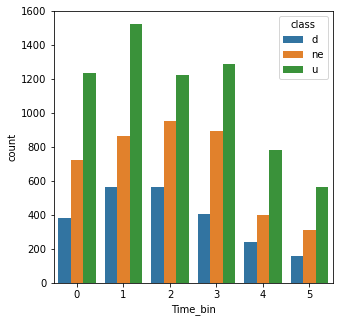

In [43]:
sns.countplot(dff['Time_bin'],hue=dff['class'])

<AxesSubplot:xlabel='Weight_of_cat', ylabel='Density'>

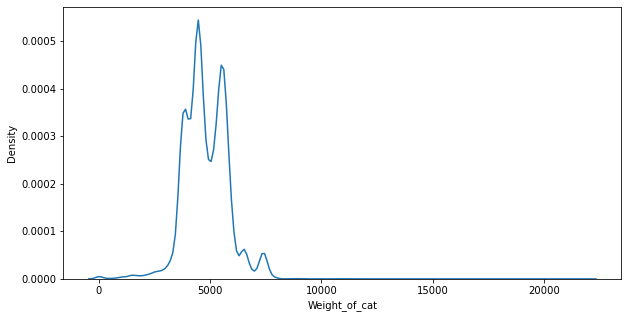

In [42]:
plt.figure(figsize=(10, 5))
sns.kdeplot(dff['Weight_of_cat'])

<AxesSubplot:xlabel='timestamp', ylabel='Density'>

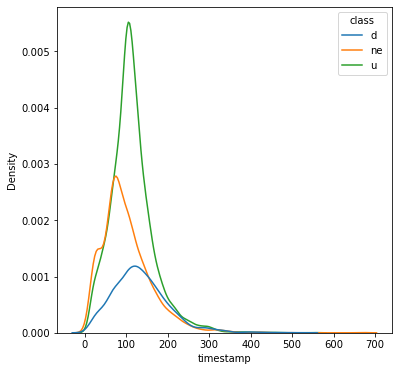

In [1142]:
sns.kdeplot(dff['timestamp'],hue=dff['class'])

In [ ]:
time=dff[dff['class']=='d']
time[time['timestamp']<30][['class','Free_text','timestamp']]

<AxesSubplot:xlabel='max_sum', ylabel='Density'>

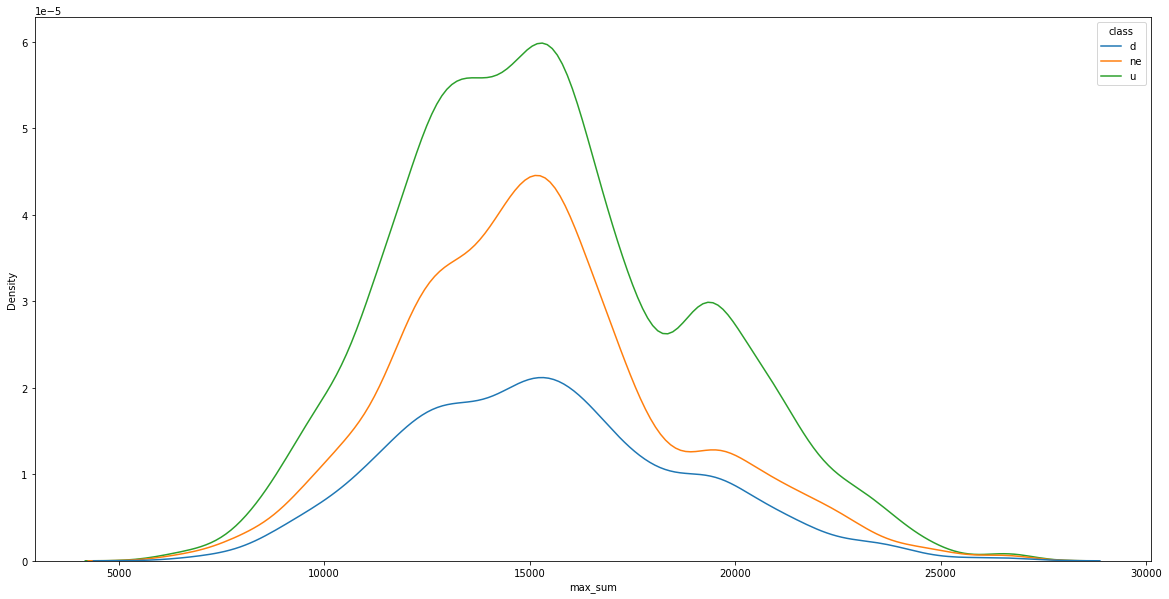

In [1280]:
sns.kdeplot(dff['max_sum'],hue=dff['class'])

<AxesSubplot:xlabel='Month', ylabel='count'>

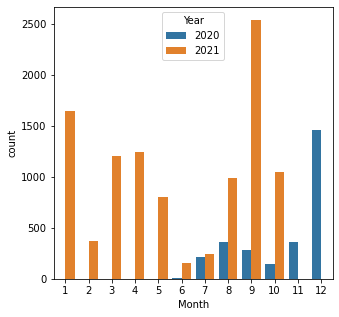

In [56]:
sns.countplot(dff['Month'],hue=dff['Year'])

<AxesSubplot:xlabel='mean_sum'>

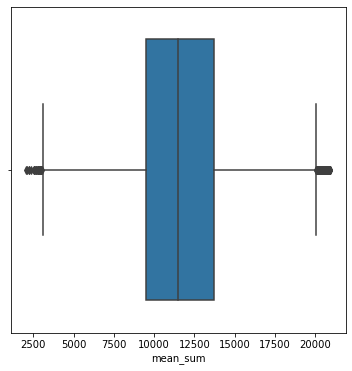

In [1194]:
sns.boxplot(dff['mean_sum'])

<AxesSubplot:xlabel='median_sum'>

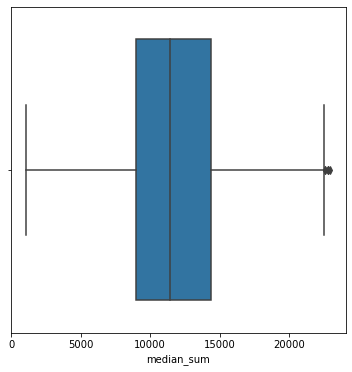

In [1193]:
sns.boxplot(dff['median_sum'])

<AxesSubplot:xlabel='Difference'>

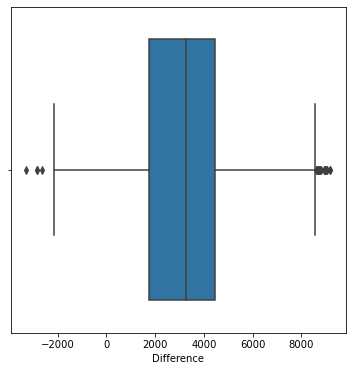

In [1188]:
sns.boxplot(dff['Difference'])

long tails from above plot represents outliers in the columns which are to be treated.

Waste is weight other than weight of the cat 

### Outlier Analysis

In [50]:
dff['waste']=dff['max_sum']-dff['Weight_of_cat']

In [53]:
dff['waste'].min()

4171.0

In [46]:
#Outlier Analysis

def iqr(x):
    IQR = np.diff(x.quantile([0.3,0.7]))[0]
    Q1 = x.quantile(0.3)
    Q3 = x.quantile(0.7)
    S = 1.5*IQR
    x[x < Q1-S] = x.median()
    x[x >Q3+S] = Q3+S
    return x



In [47]:
iqr(dff['Weight_of_cat'])

0        6589.0
1        6935.0
2        5139.0
3        6983.0
4        7005.5
          ...  
13070    4116.0
13071    4604.0
13072    4416.0
13073    4386.0
13074    4510.0
Name: Weight_of_cat, Length: 13075, dtype: float64

In [48]:
dff['Weight_of_cat'].min()

2738.0

In [49]:
iqr(dff['max_sum'])

0        16726.0
1        17484.0
2        15311.0
3        16092.0
4        12523.0
          ...   
13070    13033.0
13071    13016.0
13072    12509.0
13073    12534.0
13074    14305.0
Name: max_sum, Length: 13075, dtype: float64

In [52]:
iqr(dff['waste'])

0        10137.0
1        10549.0
2        10172.0
3         9109.0
4         5517.5
          ...   
13070     8917.0
13071     8412.0
13072     8093.0
13073     8148.0
13074     9795.0
Name: waste, Length: 13075, dtype: float64

<AxesSubplot:xlabel='max_sum', ylabel='Density'>

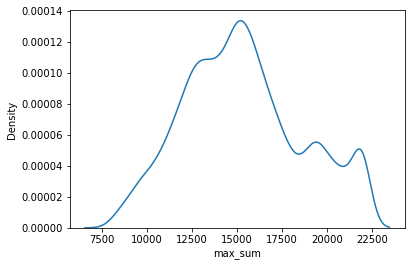

In [56]:
sns.kdeplot(dff['max_sum'])

In [57]:
outlier_cols = ['median_sum','mean_sum','Difference']


Q1 = dff[outlier_cols].quantile(0.2)
Q3 = dff[outlier_cols].quantile(0.75)
IQR=Q3-Q1
whisker_width=1.5

In [58]:
dff=dff[~((dff[outlier_cols]<Q1-whisker_width*IQR)|(dff[outlier_cols]>Q3+whisker_width*IQR)).any(axis=1)]

dff.shape

(12956, 14)

In [59]:
dff['max_sum'].skew()

0.27047131441651157

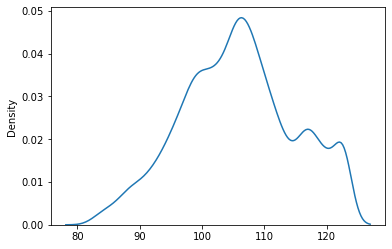

-0.014229558763450329

In [60]:
sns.kdeplot(pd.Series(stats.boxcox(dff['max_sum'])[0]))
plt.show()
pd.Series(stats.boxcox(dff['max_sum'])[0]).skew()

In [593]:
dff['Weight_of_cat'].skew()

0.623811528303633

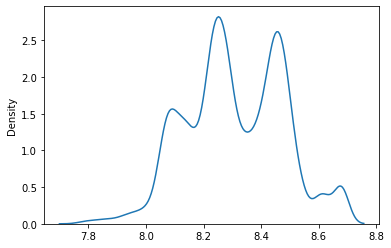

0.0001094129571614254

In [61]:
sns.kdeplot(pd.Series(stats.boxcox(dff['Weight_of_cat'])[0]))
plt.show()
pd.Series(stats.boxcox(dff['Weight_of_cat'])[0]).skew()

<AxesSubplot:>

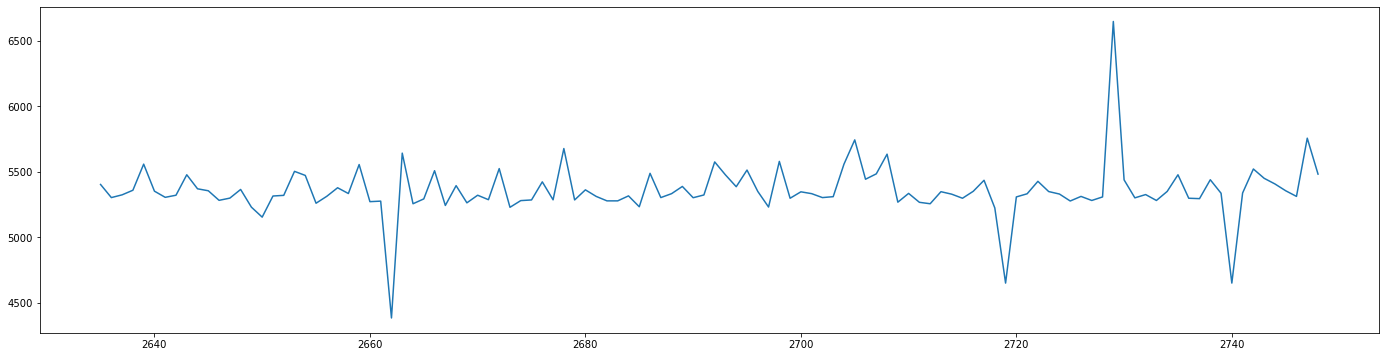

In [62]:
plt.rcParams['figure.figsize']=(24,6)
dff[dff['Name_of_cat']=='Bill']['Weight_of_cat'].plot(kind='line')

In [ ]:
sns.scatterplot(dff['mean_sum'],dff['Difference'])

### Analysing relations on the target variable of different cats

<AxesSubplot:xlabel='Name_of_cat'>

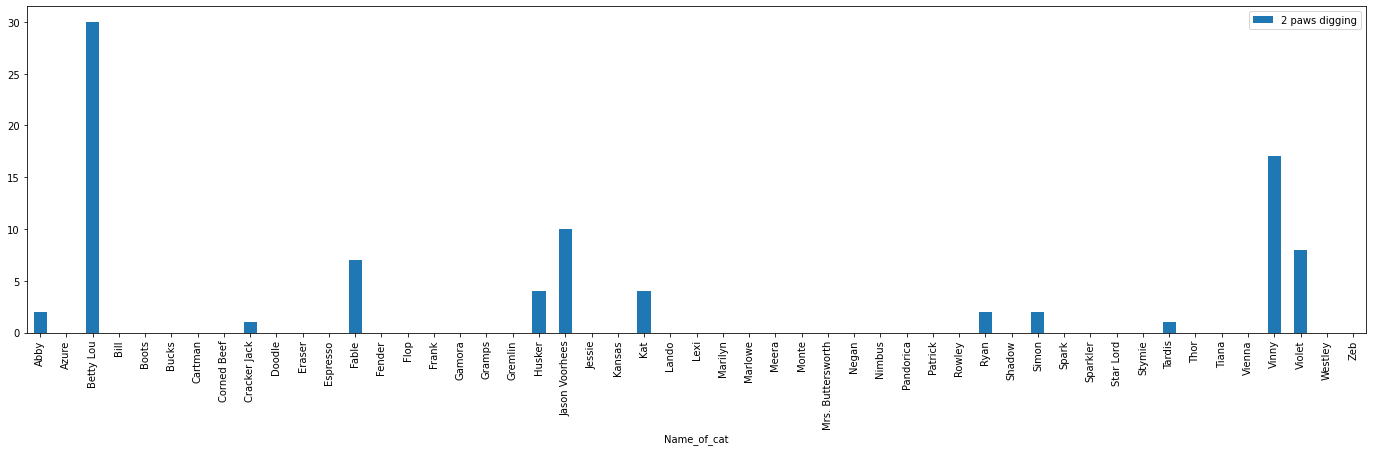

In [1378]:
plt.rcParams['figure.figsize']=(24,6)
dff_paw=dff[dff['2 paws digging']==1][['Name_of_cat','class','2 paws digging']]
dff_paw.groupby(['Name_of_cat']).agg({'2 paws digging':'count'}).plot(kind='bar')


<AxesSubplot:xlabel='Name_of_cat,class'>

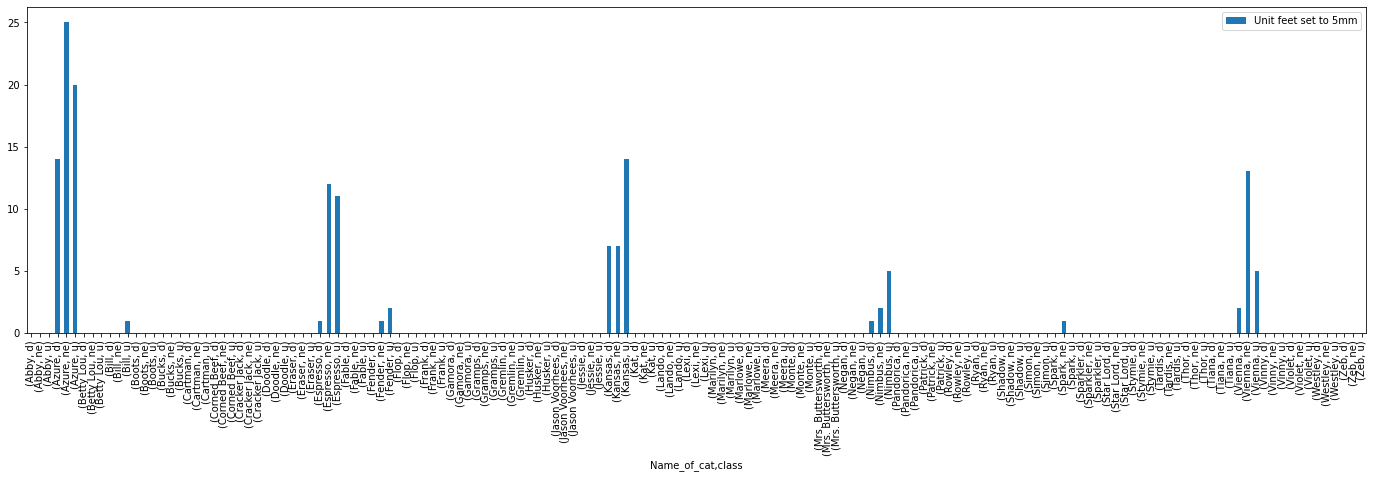

In [1382]:
dff[dff['Unit feet set to 5mm']==1].groupby(['Name_of_cat','class']).agg({'Unit feet set to 5mm':
                                                                          'count'}).plot(kind='bar')

<AxesSubplot:xlabel='Name_of_cat'>

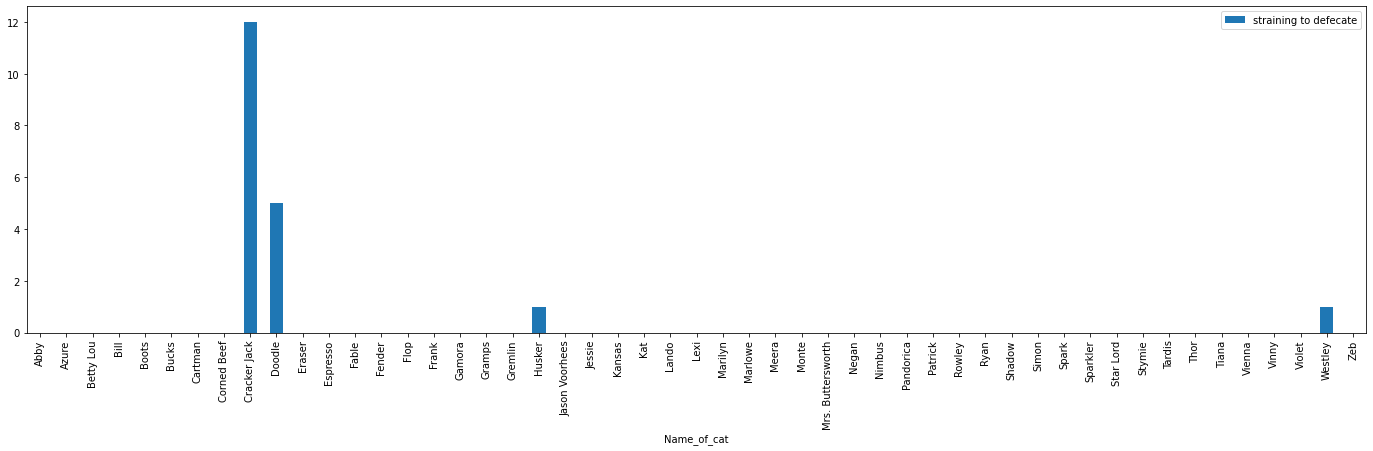

In [1379]:
plt.rcParams['figure.figsize']=(24,6)
dff[dff['straining to defecate']==1].groupby(['Name_of_cat']).agg({'straining to defecate':
                                                                          'count'}).plot(kind='bar')

<AxesSubplot:xlabel='Name_of_cat'>

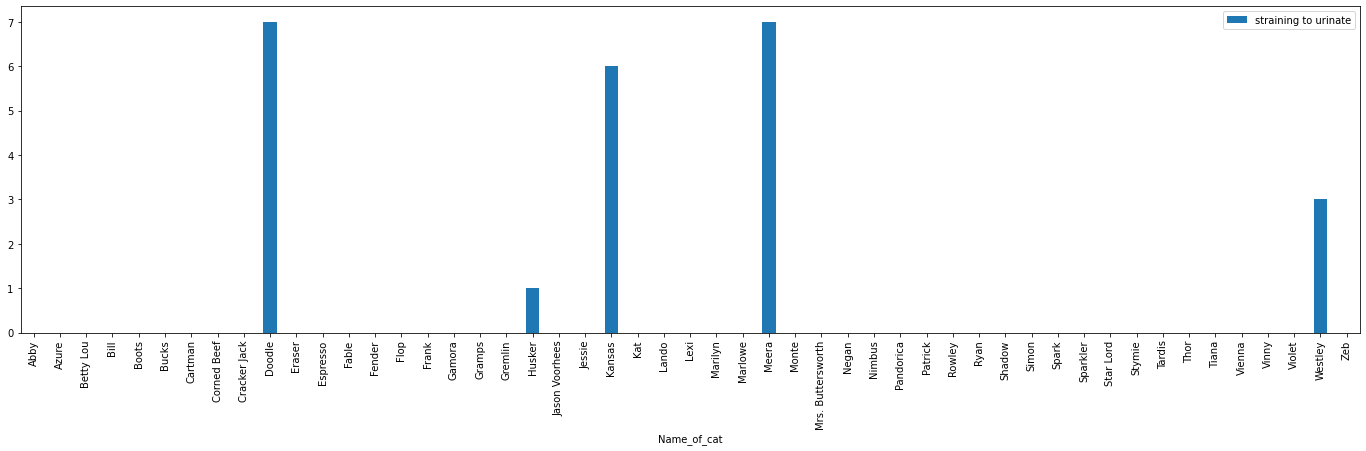

In [1381]:
plt.rcParams['figure.figsize']=(24,6)
dff[dff['straining to urinate']==1].groupby(['Name_of_cat']).agg({'straining to urinate':
                                                                          'count'}).plot(kind='bar')

In [ ]:
# function to extract mode
#dff.groupby(['Name_of_cat'])['waste'].agg(pd.Series.mode)  

In [63]:
dff.groupby(['Name_of_cat','class']).agg({'class':'count','Weight_of_cat':['mean','min','max'],
                                          'waste':['mean','min','max']})

class Weight_of_cat                         waste          \
                  count          mean     min     max          mean     min   
Name_of_cat class                                                             
Abby        d       131   4286.809160  3448.0  4691.0   8812.664122  4853.0   
            ne      103   4383.359223  3999.0  4781.0   8359.184466  4384.0   
            u       161   4325.614907  3571.0  4823.0   8982.229814  4202.0   
Azure       d        31   4445.935484  4278.0  4744.0  11725.193548  6050.0   
            ne      412   4456.006068  2918.0  7005.5  10346.691748  5877.0   
...                 ...           ...     ...     ...           ...     ...   
Westley     ne      118   5149.906780  2861.0  5783.0   6902.500000  4211.0   
            u       201   5211.860697  2758.0  5499.0   6716.895522  4185.0   
Zeb         d        22   6294.250000  3957.0  7005.5   9240.386364  4659.0   
            ne       40   6572.562500  4234.0  7005.5  10593.537500  5926.0   
            u        55   6059.090909  3191.0  7005.5   9202.800000  5479.0   

                            
                       max  
Name_of_cat class           
Abby        d      13127.0  
            ne     13690.0  
            u      13602.0  
Azure       d      15639.0  
            ne     16335.0  
...                    ...  
Westley     ne     13144.0  
            u      14636.0  
Zeb         d      14399.0  
            ne     14979.0  
            u      14565.5  

[153 rows x 7 columns]

In [67]:
#dff.drop(['Date'],axis=1,inplace=True)

<AxesSubplot:xlabel='Name_of_cat'>

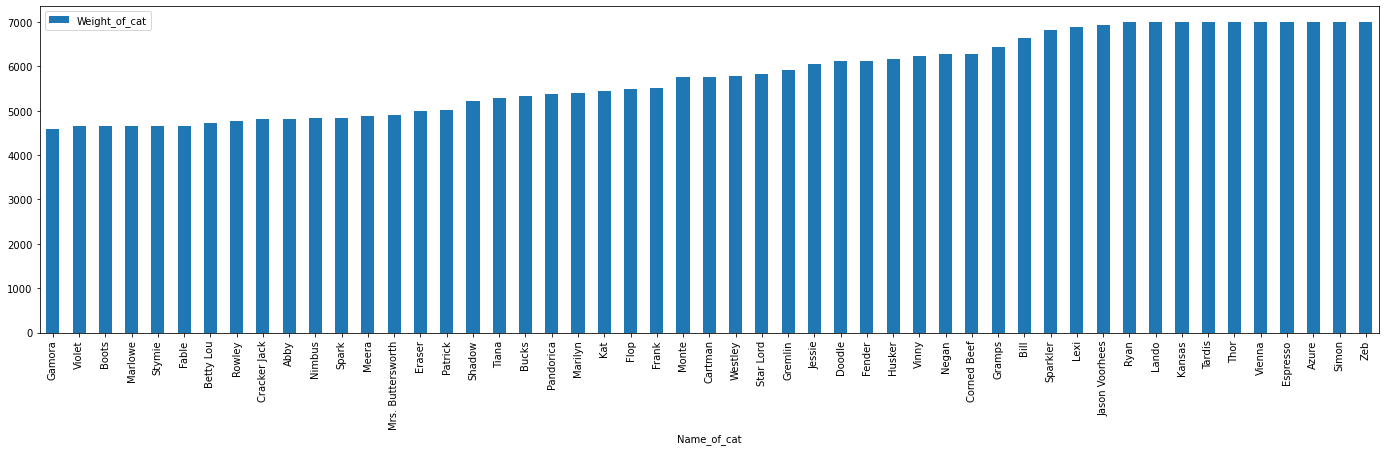

In [64]:
# max weight of the cats

plt.rcParams['figure.figsize']=(24,6)
dff.groupby(['Name_of_cat']).agg({'Weight_of_cat':'max'}).sort_values(by='Weight_of_cat').plot(kind='bar')

<AxesSubplot:xlabel='Name_of_cat'>

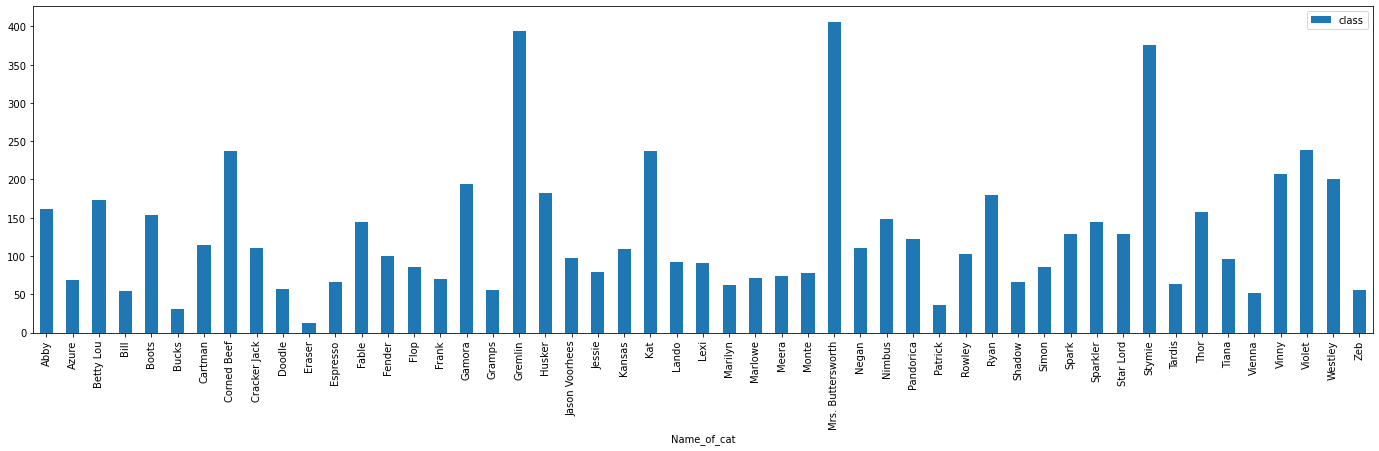

In [66]:
# Total count of eliminations of cats

dff[dff['class']=='u'].groupby(['Name_of_cat']).agg({'class':'count'}).plot(kind = 'bar')

<AxesSubplot:xlabel='Name_of_cat'>

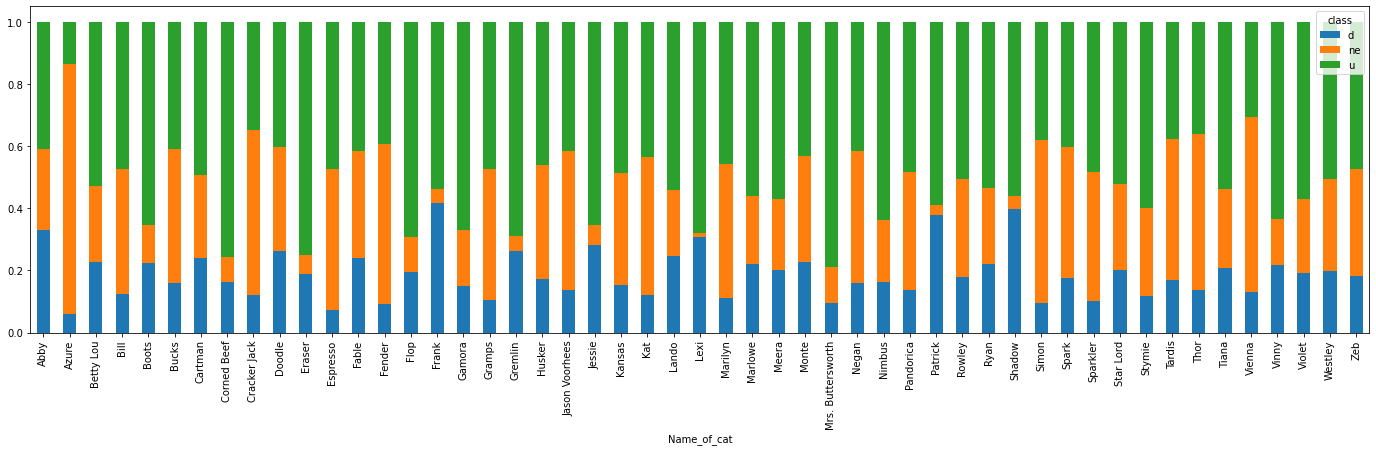

In [59]:
#percentage of elimination and non elimination of each cat.
plt.rcParams['figure.figsize']=(24,6)
pd.crosstab(dff['Name_of_cat'], dff['class'], normalize = 'index').plot(stacked=True, kind = 'bar')

### Visualising relation between weight w.r.t class of each cat

#### Visualising the tables and graph of weight of each cat at maximum, minimum and mean values

In [71]:
## weight w.r.t class

df_w=pd.crosstab(dff['Name_of_cat'],columns=dff['class'],values=dff['Weight_of_cat'],
            colnames=['Weight'],aggfunc='min',normalize='index')
df_w.head()

Weight,d,ne,u
Name_of_cat,,,
Abby,0.312942,0.362952,0.324106
Azure,0.395781,0.269960,0.334258
Betty Lou,0.386196,0.249977,0.363826
Bill,0.309020,0.327766,0.363214
Boots,0.341928,0.328013,0.330059


In [72]:
((df_w['d']-df_w['ne'])>0).sum()

33

<AxesSubplot:xlabel='Name_of_cat'>

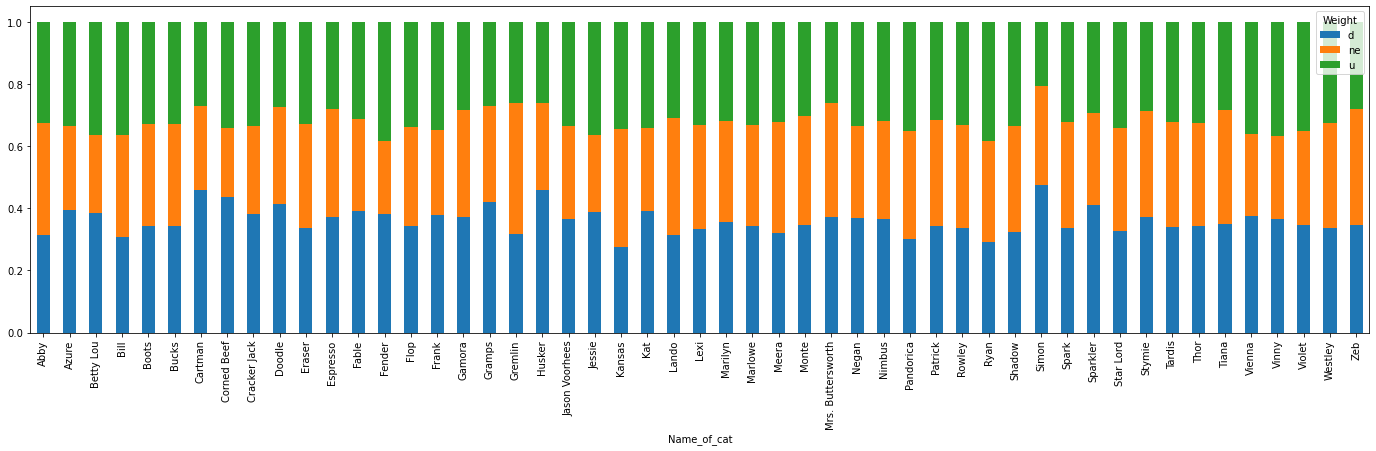

In [73]:
plt.rcParams['figure.figsize']=(24,6)
df_w.plot(stacked=True, kind = 'bar')

In [74]:
# tare weight w.r.t class

df_tw=pd.crosstab(dff['Name_of_cat'],columns=dff['class'],values=dff['max_sum'],
                 aggfunc='max',normalize='index')
df_tw.head()

class,d,ne,u
Name_of_cat,,,
Abby,0.329671,0.340023,0.330306
Azure,0.316823,0.347167,0.336010
Betty Lou,0.340734,0.318532,0.340734
Bill,0.304402,0.393121,0.302477
Boots,0.339453,0.323912,0.336635


In [78]:
((df_tw['u']-df_tw['ne'])>0).sum()

20

<AxesSubplot:xlabel='Name_of_cat'>

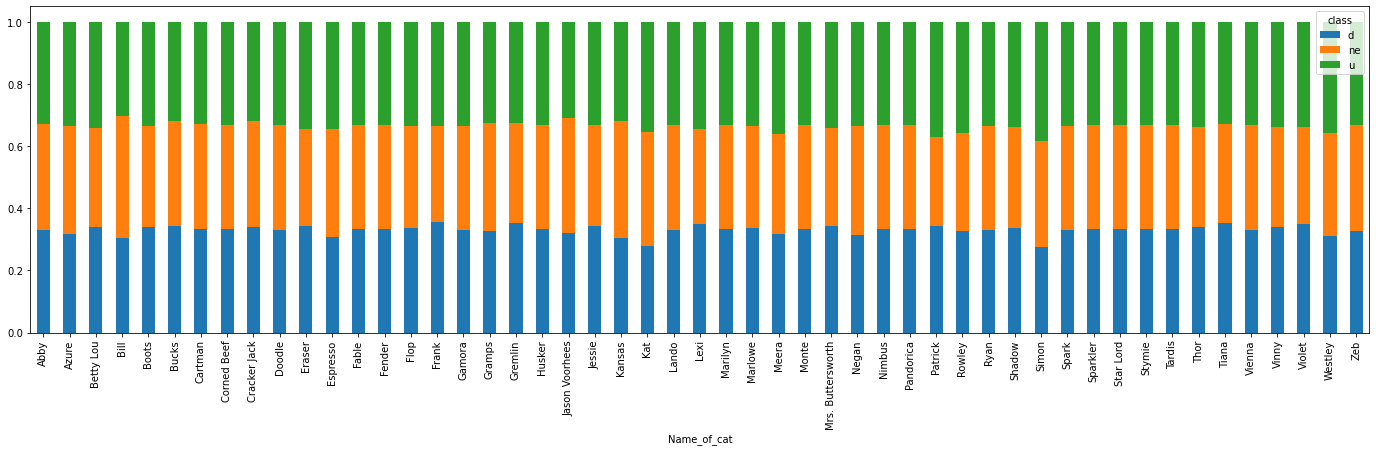

In [77]:
df_tw.plot(stacked=True, kind = 'bar')

Comparitively weight of the cat and related total weights are higher during non-elimination compared to elimination

In [189]:
dff.groupby('Name_of_cat').apply(lambda x: print(x[['Weight_of_cat','max_sum']].corr()))

               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.246285
max_sum             0.246285  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.260305
max_sum             0.260305  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.174748
max_sum             0.174748  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.209836
max_sum             0.209836  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000 -0.570463
max_sum            -0.570463  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.201278
max_sum             0.201278  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.678723
max_sum             0.678723  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000000  0.037144
max_sum             0.037144  1.000000
               Weight_of_cat   max_sum
Weight_of_cat       1.000

""


In [190]:
dff.groupby('Name_of_cat').apply(lambda x: print(x[['Weight_of_cat','median_sum']].corr()))

               Weight_of_cat    median
Weight_of_cat       1.000000 -0.003744
median             -0.003744  1.000000
               Weight_of_cat    median
Weight_of_cat       1.000000 -0.076589
median             -0.076589  1.000000
               Weight_of_cat    median
Weight_of_cat       1.000000  0.081251
median              0.081251  1.000000
               Weight_of_cat   median
Weight_of_cat        1.00000 -0.29418
median              -0.29418  1.00000
               Weight_of_cat    median
Weight_of_cat       1.000000 -0.589825
median             -0.589825  1.000000
               Weight_of_cat  median
Weight_of_cat         1.0000 -0.0325
median               -0.0325  1.0000
               Weight_of_cat    median
Weight_of_cat       1.000000  0.309998
median              0.309998  1.000000
               Weight_of_cat    median
Weight_of_cat       1.000000  0.167635
median              0.167635  1.000000
               Weight_of_cat   median
Weight_of_cat        1.00000 -0.325

""


In [194]:
dff.groupby('Name_of_cat').apply(lambda x: print(x[['max_sum','Tare_weight']].corr()))

              max_sum  Tare_weight
max_sum      1.000000     0.604964
Tare_weight  0.604964     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.505395
Tare_weight  0.505395     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.246744
Tare_weight  0.246744     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.079157
Tare_weight  0.079157     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.990779
Tare_weight  0.990779     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.368554
Tare_weight  0.368554     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.174692
Tare_weight  0.174692     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.760293
Tare_weight  0.760293     1.000000
              max_sum  Tare_weight
max_sum      1.000000     0.786301
Tare_weight  0.786301     1.000000
              max_sum  Tare_weight
max_sum      1.00000

ValueError: zero-size array to reduction operation fmin which has no identity

##### weight of the cat is correlated with the tare weight and maximum sum of the sensor data

In [79]:
# residual weight w.r.t class

df_rw=pd.crosstab(dff['Name_of_cat'],columns=dff['class'],values=dff['waste'],
            colnames=['Residual Weight'],aggfunc='max',normalize='index')
df_rw.head()

Residual Weight,d,ne,u
Name_of_cat,,,
Abby,0.324773,0.338702,0.336525
Azure,0.323728,0.338136,0.338136
Betty Lou,0.334501,0.330999,0.334501
Bill,0.293942,0.416426,0.289631
Boots,0.333333,0.333333,0.333333


<AxesSubplot:xlabel='Name_of_cat'>

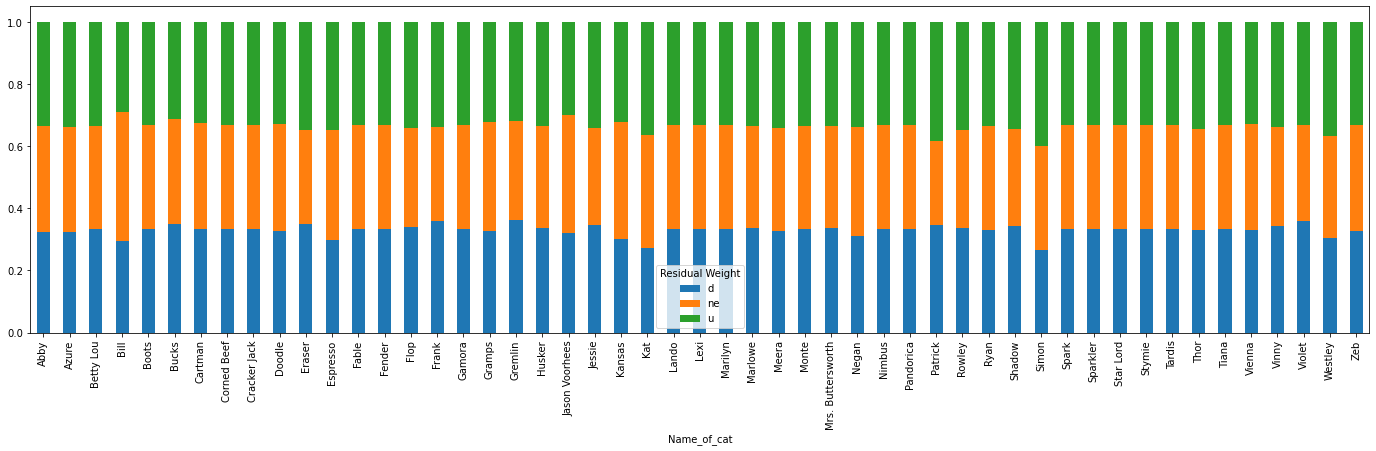

In [80]:
df_rw.plot(stacked=True, kind = 'bar')

Residual weight or combined weight of litter and box are comparitively high during elimination than non elimination

In [82]:
((df_rw['d']-df_rw['ne'])>0).sum()

16

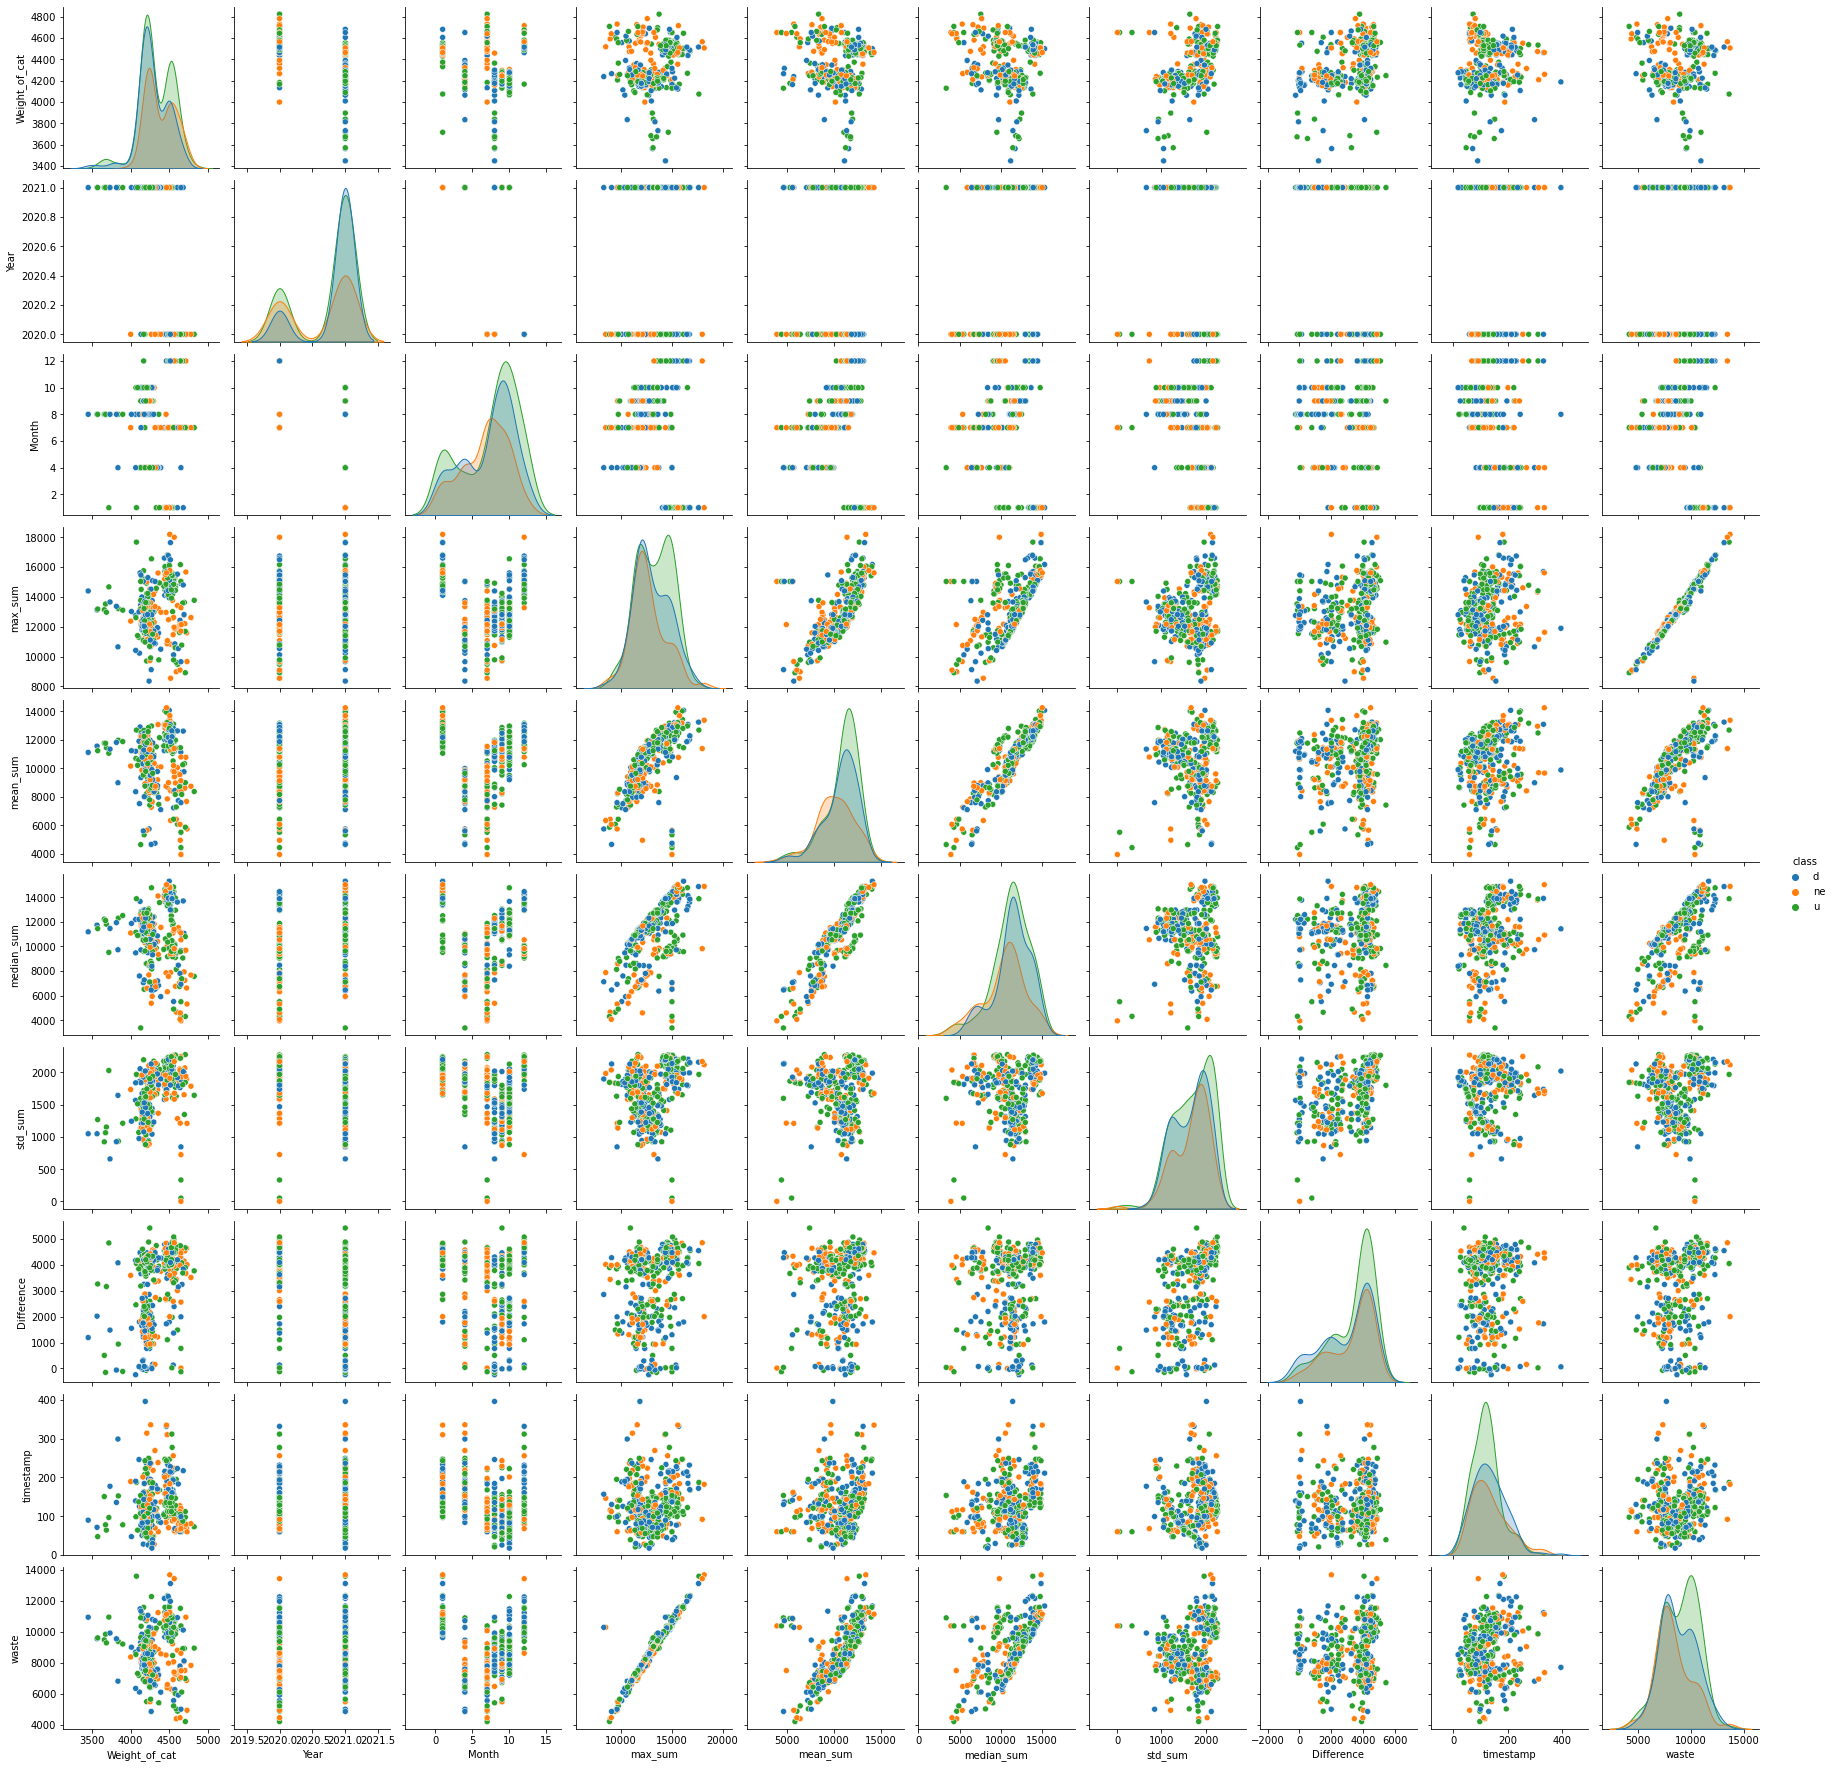

In [83]:
sns.pairplot(dff[dff['Name_of_cat']=='Abby'],hue='class')

<AxesSubplot:>

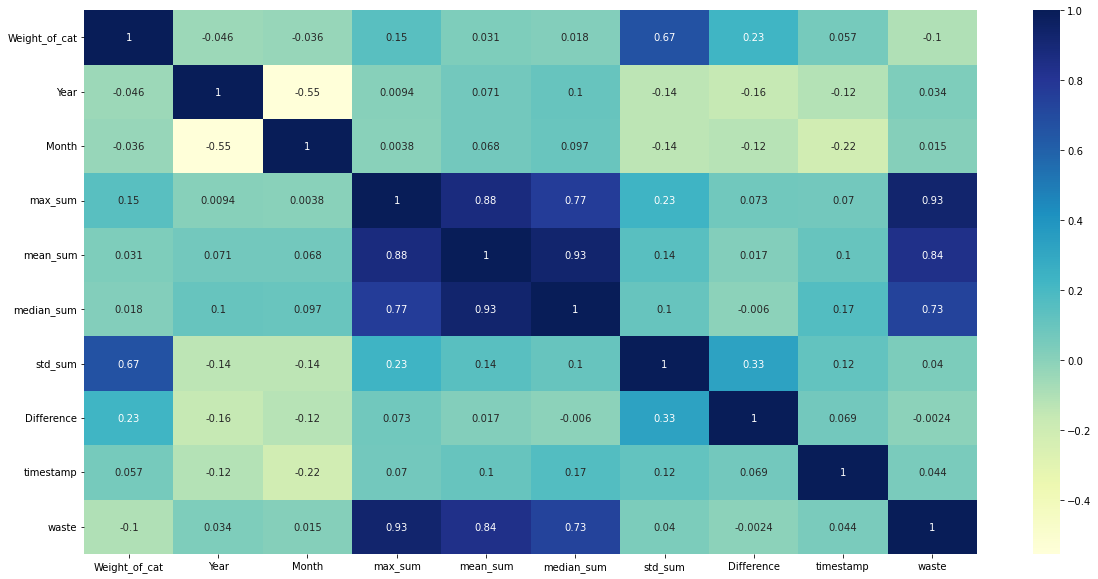

In [46]:
plt.rcParams['figure.figsize']=(20,10)
#mask = np.triu(np.ones_like(dff.corr()))
#sns.heatmap(dff.corr(), cmap="YlGnBu", annot=True, mask=mask)
sns.heatmap(dff.corr(), cmap="YlGnBu", annot=True)

### Visualising relation with date&time

In [100]:
pd.crosstab([dff['Year']],dff['Month'])

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2020,0,0,0,0,0,3,184,319,278,128,340,1269
2021,1373,326,955,1070,741,150,213,797,2025,865,0,0


<AxesSubplot:xlabel='Year,Month'>

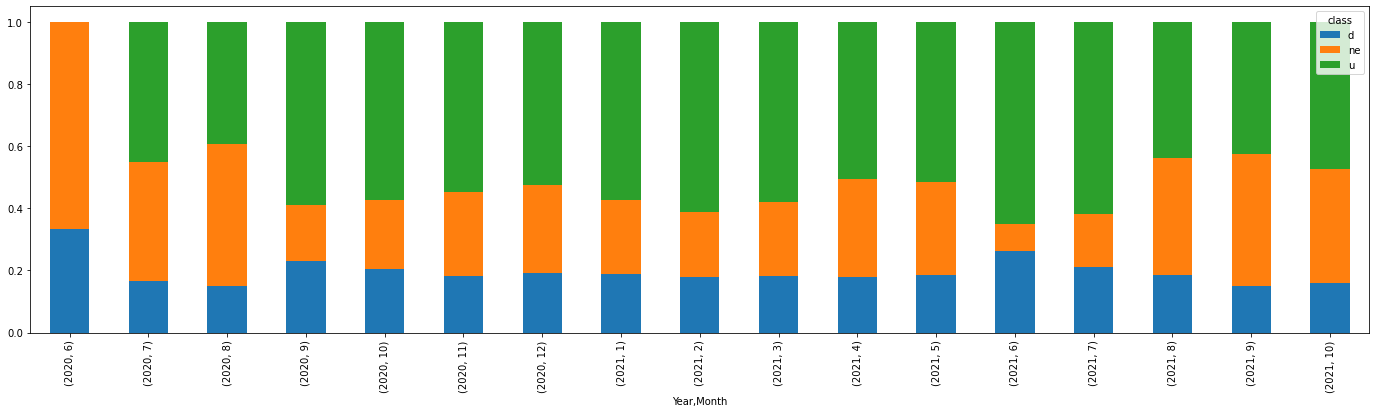

In [84]:
pd.crosstab([dff['Year'],dff['Month']],dff['class'],
            normalize = 'index').plot(stacked=True, kind = 'bar')

In [ ]:
dff[dff['Name_of_cat']=='Abby'].groupby(['Year','Month'])['class'].value_counts()

In [120]:
# frequency of eliminations of a cat in total duration

dff[dff['Name_of_cat']=='Abby'].groupby(['Date','class'])['class'].count()

Date        class
2020-07-07  e        3
            ne       0
2020-07-08  e        2
            ne       3
2020-07-09  e        2
                    ..
2021-10-11  ne       0
2021-10-12  e        5
            ne       2
2021-10-13  e        0
            ne       1
Name: class, Length: 216, dtype: int64

In [121]:
# frequency of eliminations of each cat on each day

df_n=pd.crosstab([dff['Name_of_cat'],dff['Date']],dff['class'])
df_n

class                   e  ne
Name_of_cat Date             
Abby        2020-07-07  3   0
            2020-07-08  2   3
            2020-07-09  2   3
            2020-07-10  2   0
            2020-07-15  0   4
...                    ..  ..
Zeb         2021-08-20  0   1
            2021-08-21  0   1
            2021-09-01  1   0
            2021-09-03  0   1
            2021-09-07  1   0

[4414 rows x 2 columns]

## Hypothesis Testing 

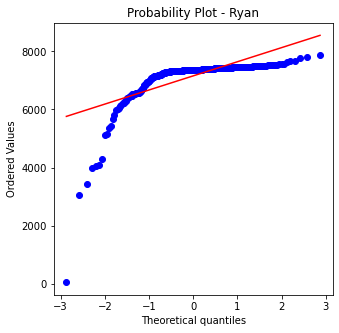

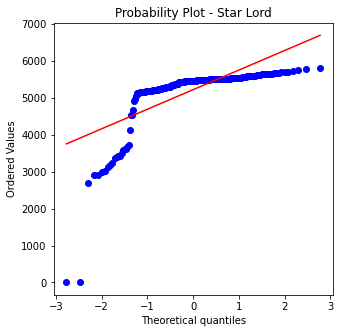

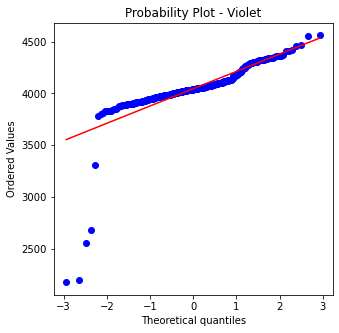

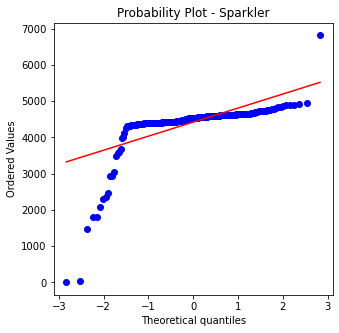

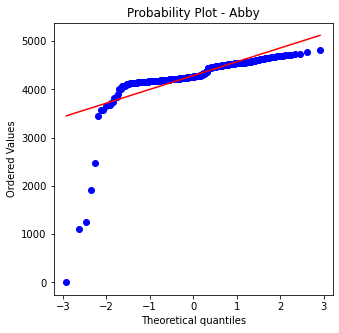

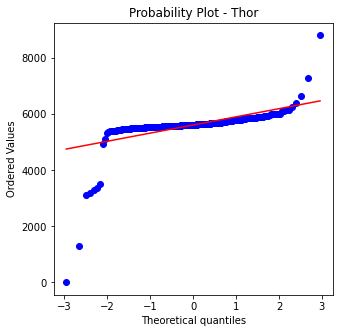

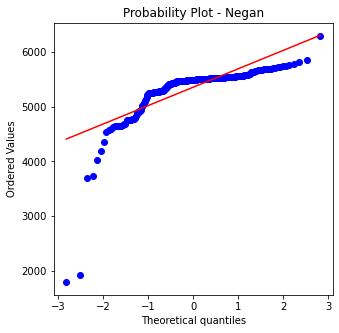

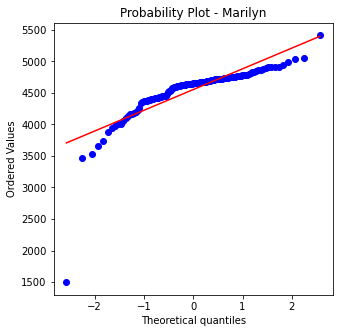

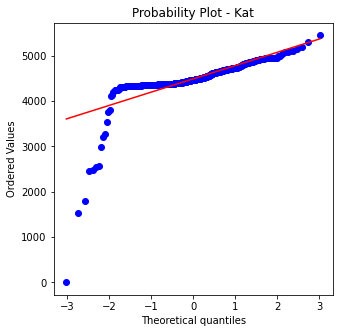

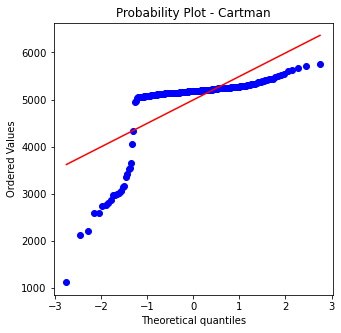

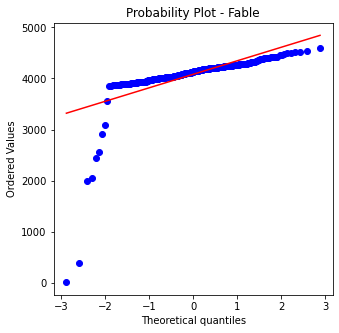

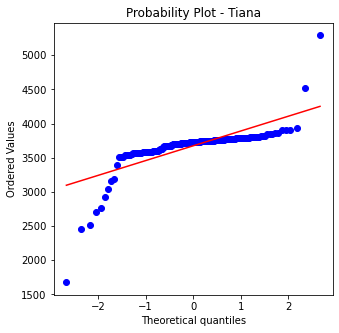

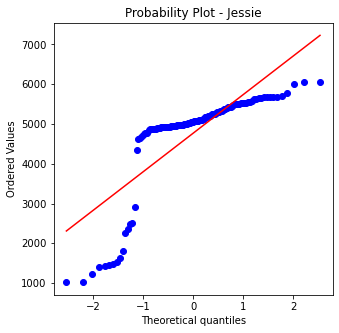

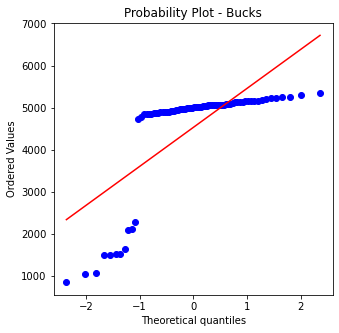

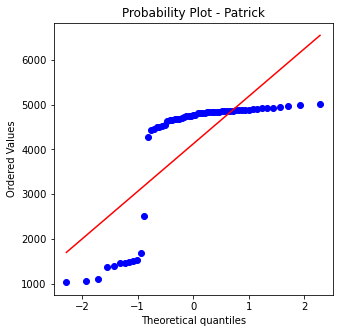

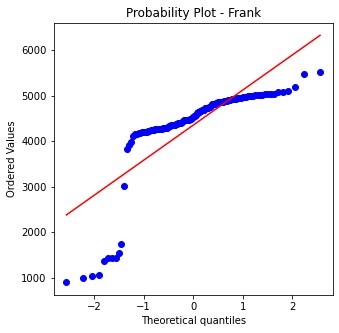

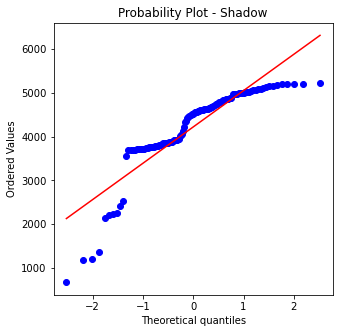

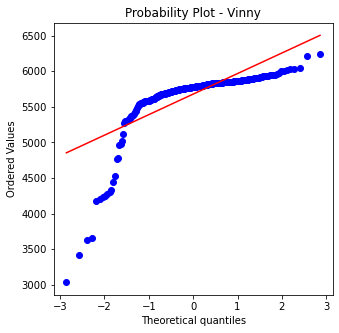

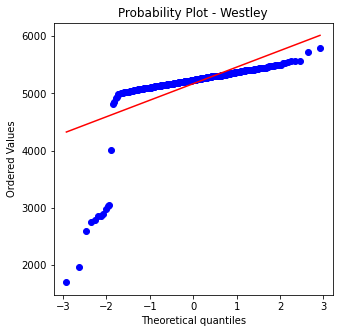

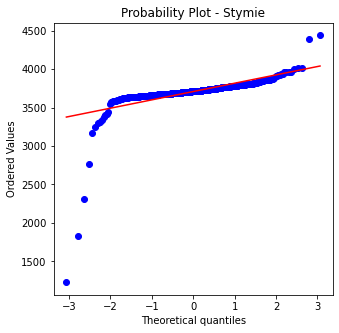

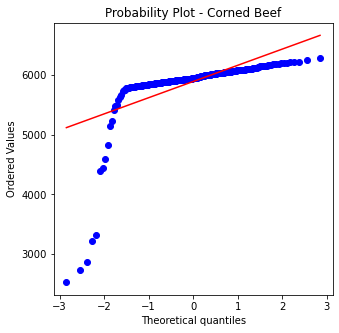

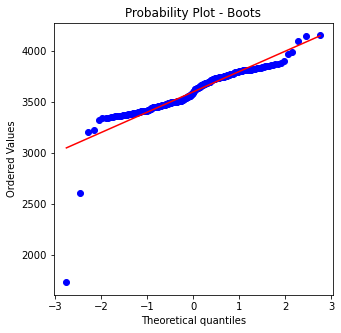

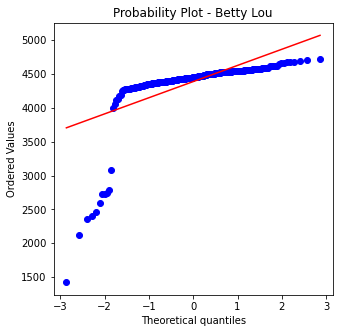

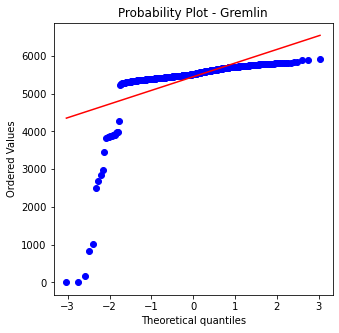

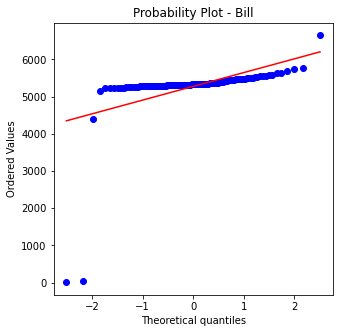

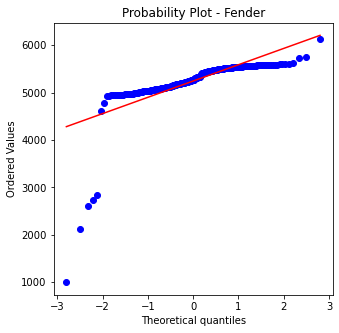

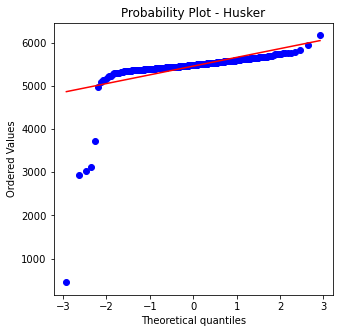

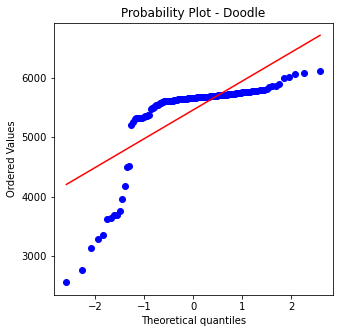

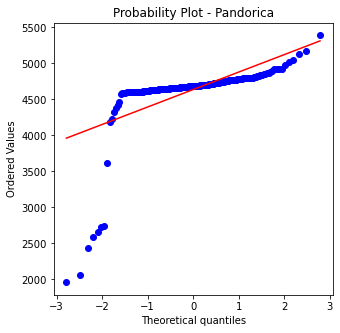

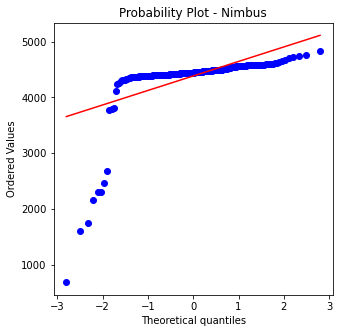

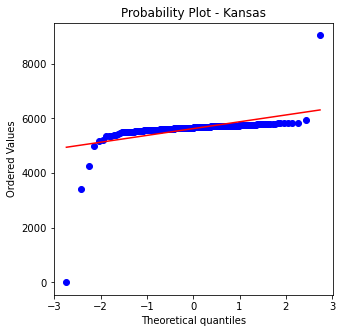

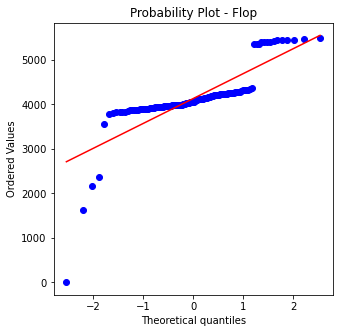

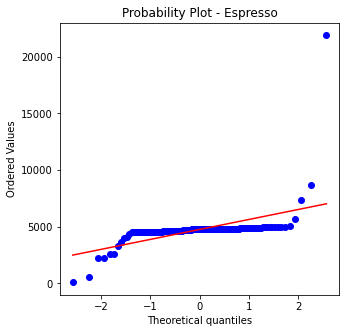

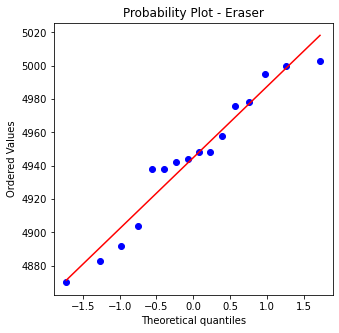

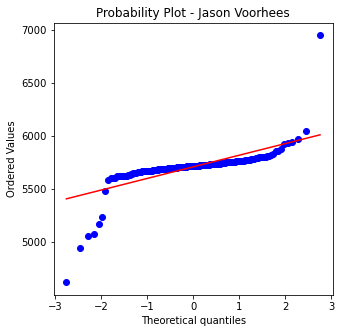

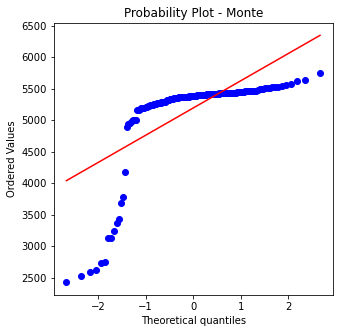

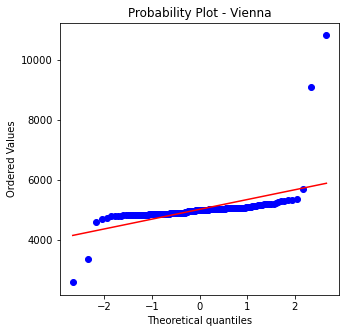

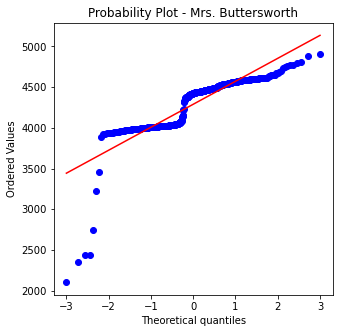

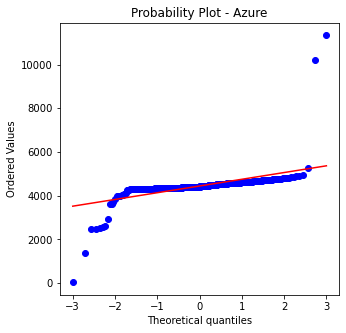

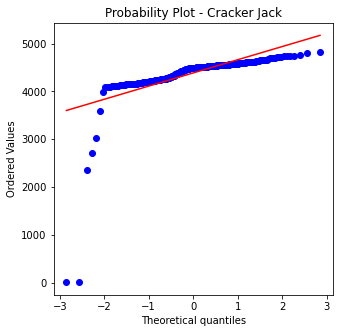

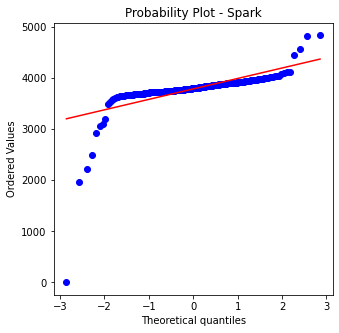

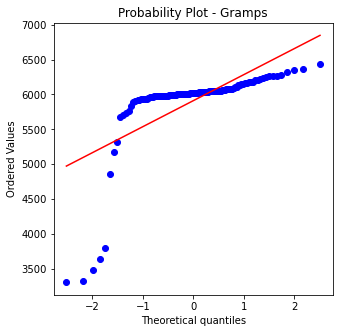

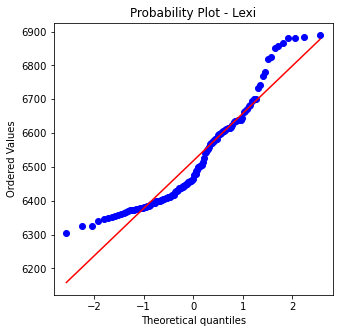

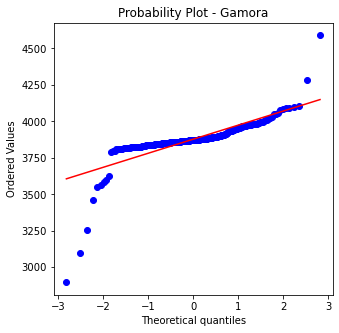

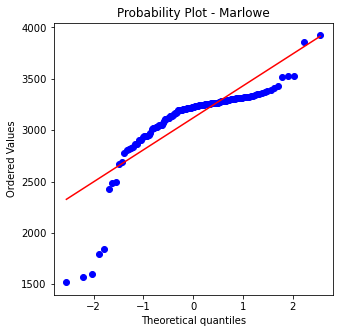

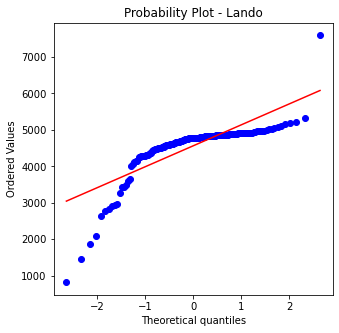

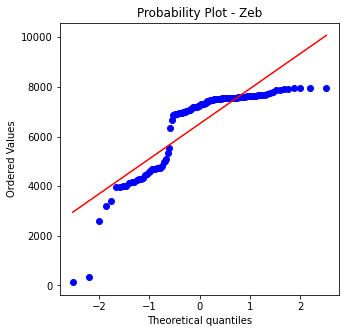

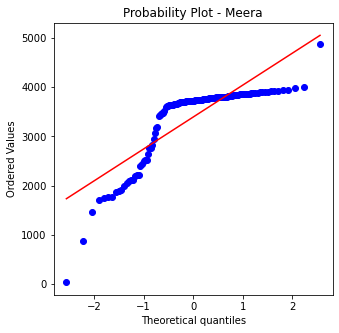

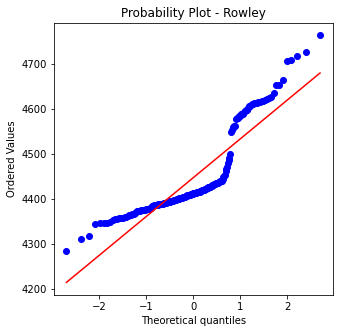

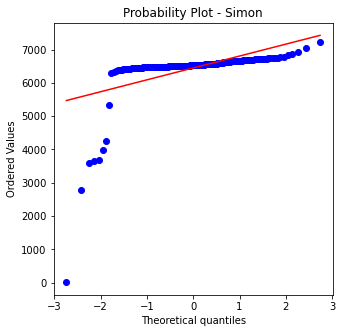

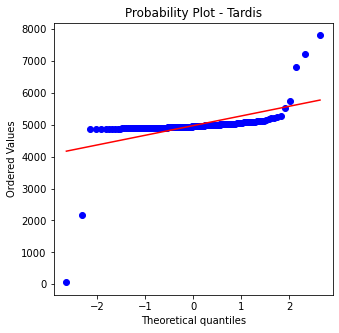

In [89]:
import scipy.stats as stats

names=df1['Name_of_cat'].unique()

for i in names:
    plt.rcParams['figure.figsize']=(5,5)
    stats.probplot(df1[df1['Name_of_cat'] == i]['Weight_of_cat'],plot=plt)
    plt.title("Probability Plot - " +  i)
    plt.show()

In [90]:
mm={'Name_of_cat':[],'min':[],'max':[],'urinate':[],'defcate':[],'weight':[]}
for i in names:
    dff_n=dff[dff['Name_of_cat']==i]
    mm['min'].append(dff_n['Date'].min())
    mm['max'].append(dff_n['Date'].max())
    mm['Name_of_cat'].append(i)
    mm['urinate'].append(dff_n[dff_n['class']=='u']['class'].count())
    mm['defcate'].append(dff_n[dff_n['class']=='d']['class'].count())
    mm['weight'].append(dff_n['Weight_of_cat'].mean())
    
df_days=pd.DataFrame(mm)
df_days['Total_days']=df_days['max']-df_days['min']
df_days=df_days.sort_values(by='min')

df_days.head()

,Name_of_cat,min,max,urinate,defcate,weight,Total_days
1,Star Lord,2020-06-29,2021-01-28,129,45,5268.971193,213 days
2,Violet,2020-07-07,2021-10-04,239,81,4066.521429,454 days
3,Sparkler,2020-07-07,2021-10-05,145,30,4511.676667,455 days
4,Abby,2020-07-07,2021-10-13,161,131,4327.802532,463 days
0,Ryan,2020-07-08,2021-10-05,180,75,6859.063609,454 days


In [91]:
df_days['Total_days'] = df_days['Total_days'].dt.days.astype('int16')

In [95]:
mapping = {0: 'ne',1: 'u',2: 'd'}
dff['class'] = dff['class'].replace(mapping)

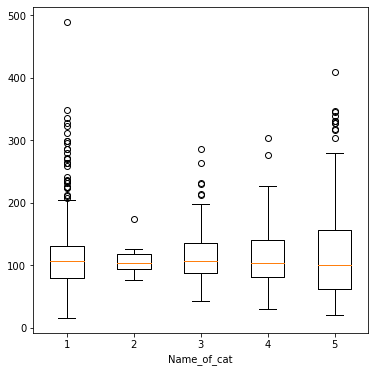

In [99]:
sample_1 = (dff.groupby(['Name_of_cat']).get_group('Stymie'))['timestamp']
sample_2 = (dff.groupby(['Name_of_cat']).get_group('Eraser'))['timestamp']
sample_3 = (dff.groupby(['Name_of_cat']).get_group('Monte'))['timestamp']
sample_4 = (dff.groupby(['Name_of_cat']).get_group('Meera'))['timestamp']
sample_5 = (dff.groupby(['Name_of_cat']).get_group('Rowley'))['timestamp']

plt.boxplot([sample_1,sample_2,sample_3,sample_4,sample_5])
plt.xlabel('Name_of_cat')
plt.show()

In [100]:
import scipy.stats as stats
stats.f_oneway(sample_1, sample_2, sample_3, sample_4,sample_5)


F_onewayResult(statistic=0.982901351931293, pvalue=0.41579332768168464)

f-value < 1 i.e., samples have similar mean 

p value>0.05 so failed to reject null hypothesis i.e no proper evidence to prove statistically significant difference between samples

Eraser,Monte,Rowley  have same behaviour pattern

In [326]:
for i in names:
    sample=dff.groupby(['Name_of_cat']).get_group(i)[['Time_bin','timestamp','class']]
    F,p=stats.f_oneway(sample,df_test)

mc = statsmodels.stats.multicomp.MultiComparison(dff['Month'],dff['Name_of_cat'])
mc_results = mc.tukeyhsd()
print(mc_results)

            Multiple Comparison of Means - Tukey HSD, FWER=0.05            
      group1            group2      meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------
             Abby             Azure   1.7948    0.0   0.9677  2.6218   True
             Abby         Betty Lou   -0.738 0.4628   -1.661  0.1849  False
             Abby              Bill   3.9088    0.0   2.5952  5.2224   True
             Abby             Boots  -4.6843    0.0  -5.7035 -3.6651   True
             Abby             Bucks   0.1325    1.0  -1.4151    1.68  False
             Abby           Cartman   0.0229    1.0  -0.9991  1.0449  False
             Abby       Corned Beef  -1.0317 0.0097  -1.9658 -0.0976   True
             Abby      Cracker Jack   -2.929    0.0  -3.8583 -1.9998   True
             Abby            Doodle  -5.6256    0.0  -6.8283 -4.4229   True
             Abby            Eraser   3.1522 0.0497   0.0015  6.3029   True
            

In [327]:
df_tukey = pd.DataFrame(data=mc_results._results_table.data[1:], columns=mc_results._results_table.data[0])
df_tukey.head()

,group1,group2,meandiff,p-adj,lower,upper,reject
0,Abby,Azure,1.7948,0.0000,0.9677,2.6218,True
1,Abby,Betty Lou,-0.7380,0.4628,-1.6610,0.1849,False
2,Abby,Bill,3.9088,0.0000,2.5952,5.2224,True
3,Abby,Boots,-4.6843,0.0000,-5.7035,-3.6651,True
4,Abby,Bucks,0.1325,1.0000,-1.4151,1.6800,False


p<0.05 i.e null hypothesis is rejected or there is a statistically significant difference between the means of Abby and Azure.

Abby related with ['Cartman', 'Fable', 'Monte', 'Nimbus', 'Patrick', 'Star Lord']

Cartman  ['Corned Beef','Eraser','Fable','Husker','Jessie','Monte','Nimbus','Patrick','Star Lord']


In [434]:
from math import log
stats.shapiro(stats.boxcox(dff['Weight_of_cat'])[0])


ShapiroResult(statistic=0.9887373447418213, pvalue=8.861347554634213e-31)

p-value< 0.05 then we reject the null hypothesis i.e. sample does not come from a normal distribution.

In [49]:
p_value=stats.levene(dff['Weight_of_cat'],dff['class'])
p_value

LeveneResult(statistic=20116.736275124647, pvalue=0.0)

In [242]:
stats.f_oneway(dff['Weight_of_cat'],dff['max_sum'])

F_onewayResult(statistic=102359.29258998702, pvalue=0.0)

f-value > 1 i.e., samples have different mean 

p-value obtained from one way Anova analysis states that there is significant difference between samples mean

In [50]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dff['Weight_of_cat'], groups=dff['class'], alpha=0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1  -8.5356 0.8767 -49.4703  32.399  False
     0      2  16.4314 0.7522 -37.1282  69.991  False
     1      2   24.967 0.4683 -24.8475 74.7815  False
-----------------------------------------------------


In [436]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dff['max_sum'], groups=dff['class'], alpha=0.05)
print(tukey)

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     d     ne -90.9207 0.5977 -311.2876 129.4463  False
     d      u  87.0135 0.5804 -118.0932 292.1202  False
    ne      u 177.9341 0.0352    9.6593 346.2089   True
-------------------------------------------------------


Between ne and u p<0.05 i.e., there is difference in total weight 

between d and ne, d and u p>0.05 i.e failed to reject null hypothesis may have similar weights

In [103]:
def anova_test(data, variable):
    
    x = ['Weight_of_cat','max_sum','mean_sum','timestamp']
    for i,k in enumerate(x):
        lm = ols('{} ~ {}'.format(x[i],variable), data=data).fit()
        table = sm.stats.anova_lm(lm)
        print("P-value for 1-way ANOVA test between {} and {} is ".format(x[i],variable),table.loc[variable,'PR(>F)'])
        

In [104]:
anova_test(dff, 'Time_bin')

P-value for 1-way ANOVA test between Weight_of_cat and Time_bin is  2.629922985443795e-24
P-value for 1-way ANOVA test between max_sum and Time_bin is  5.727388418917934e-23
P-value for 1-way ANOVA test between mean_sum and Time_bin is  1.852789708548754e-12
P-value for 1-way ANOVA test between timestamp and Time_bin is  2.1973549010095258e-43


In [105]:
anova_test(dff, 'Difference')

P-value for 1-way ANOVA test between Weight_of_cat and Difference is  3.5477556750939283e-150
P-value for 1-way ANOVA test between max_sum and Difference is  1.2581557681936826e-12
P-value for 1-way ANOVA test between mean_sum and Difference is  0.052983148309154
P-value for 1-way ANOVA test between timestamp and Difference is  3.467345495002139e-15


In [ ]:
multiple_variables=ols('Weight_of_cat ~ C(Time_bin) + C(median_sum) + C(Time_bin):C(median_sum)'
                       ,data=dff).fit()

In [445]:
import statsmodels.stats.api as sms
sms.anova_lm(multiple_variables, typ=2)

,sum_sq,df,F,PR(>F)
C(Time_bin),2.979523e+06,5.0,5.284052,7.474414e-05
C(Name_of_cat),8.578074e+09,50.0,1521.283378,0.000000e+00
C(Month),2.830120e+07,11.0,22.814058,5.355282e-47
Residual,1.466966e+09,13008.0,NaN,NaN


In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=dff['mean_sum'], groups=dff['class'], alpha=0.05)
print(tukey)

In [1233]:
dff.reset_index(inplace=True)

In [1238]:
dff.drop(['Date','Free_text','index'],axis=1,inplace=True)

In [1234]:
dff['Year']=dff['Year'].astype('category')
dff['Month']=dff['Month'].astype('category')
#dff['2 paws digging']=dff['2 paws digging'].astype('category')
#dff['Unit feet set to 5mm']=dff['Unit feet set to 5mm'].astype('category')
#dff['straining to eliminate']=dff['straining to eliminate'].astype('category')

In [1239]:
num_cols = list(dff.select_dtypes([np.number]).columns)
categorical_cols = list(set(dff.columns) - set(num_cols))
categorical_cols
#categorical_cols=['Time_bin', 'Year', 'Name_of_cat']

['Year', 'class', 'Month', 'Name_of_cat', 'Time_bin']

In [1240]:
num_cols

['Weight_of_cat',
 'max_sum',
 'mean_sum',
 'median_sum',
 'std_sum',
 'Difference',
 'timestamp',
 'waste']

In [1241]:
dff_c= pd.get_dummies(data = dff, columns =categorical_cols )
#dff_1.drop(['class_ne'],axis=1,inplace=True)
#df_c.reset_index()

In [1242]:
dff_c

,Weight_of_cat,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp,waste,Year_2020,Year_2021,...,Name_of_cat_Vinny,Name_of_cat_Violet,Name_of_cat_Westley,Name_of_cat_Zeb,Time_bin_0,Time_bin_1,Time_bin_2,Time_bin_3,Time_bin_4,Time_bin_5
0,6589,16726.0,11558.403454,9910.0,2582.242862,3450,151.974936,10137.0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,6935,17484.0,12570.468750,9348.0,3449.833733,4222,111.975000,10549.0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,5139,15311.0,11050.497559,8875.0,2572.058837,1002,102.374944,10172.0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,6983,16092.0,9855.522214,8795.0,2384.826901,6742,66.374940,9109.0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,7017,12523.0,9104.087985,11514.0,3173.569037,6715,82.375000,5506.0,1,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12952,4116,13033.0,10371.323902,11132.5,1583.759646,2791,59.125914,8917.0,0,1,...,0,0,0,0,1,0,0,0,0,0
12953,4604,13016.0,8288.571913,7759.0,1390.112340,40,132.144766,8412.0,0,1,...,0,0,0,0,0,1,0,0,0,0
12954,4416,12509.0,10081.067558,11898.0,2186.598508,4335,137.820918,8093.0,0,1,...,0,0,0,0,1,0,0,0,0,0
12955,4386,12534.0,10523.452943,10717.0,943.049529,5261,205.381823,8148.0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [1243]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(dff[num_cols])
df_o=scaler.transform(dff[num_cols])

df_o=pd.DataFrame(df_o,columns=num_cols)
df_o

,Weight_of_cat,max_sum,mean_sum,median_sum,std_sum,Difference,timestamp,waste
0,1.968919,0.413536,-0.061253,-0.464216,1.043079,0.199711,0.672622,-0.102988
1,2.363838,0.632085,0.235456,-0.607428,2.554803,0.611923,-0.013199,0.029274
2,0.313913,0.005559,-0.210157,-0.727960,1.025334,-1.107406,-0.177797,-0.091752
3,2.418624,0.230739,-0.560490,-0.748346,0.699094,1.957485,-0.795038,-0.433001
4,2.457431,-0.798285,-0.780789,-0.055476,2.073429,1.943068,-0.520708,-1.589650
...,...,...,...,...,...,...,...,...
12952,-0.853722,-0.651240,-0.409271,-0.152692,-0.696717,-0.152164,-0.919327,-0.494637
12953,-0.296727,-0.656142,-1.019876,-1.012345,-1.034135,-1.621069,0.332623,-0.656754
12954,-0.511307,-0.802322,-0.494366,0.042377,0.353693,0.672260,0.429944,-0.759161
12955,-0.545548,-0.795114,-0.364671,-0.258572,-1.813115,1.166700,1.588314,-0.741505


In [1244]:
dff_c[num_cols]=df_o[num_cols]

In [1245]:
dff_c.drop(['Name_of_cat_Abby','Time_bin_0','Month_1','Year_2020','class_ne'],axis=1,inplace=True)

In [1246]:
dff_c.isnull().sum()

Weight_of_cat    0
max_sum          0
mean_sum         0
median_sum       0
std_sum          0
                ..
Time_bin_1       0
Time_bin_2       0
Time_bin_3       0
Time_bin_4       0
Time_bin_5       0
Length: 77, dtype: int64

In [844]:
from sklearn.utils import resample

df_maj = dff_c[dff_c.class_e == 1]
df_min = dff_c[dff_c.class_e== 0]
 
# Downsample majority class
df_down_sampled = resample(df_maj, replace=False, n_samples=len(df_min), random_state=11)
dff_c = df_down_sampled.append(df_min)
print(dff_c['class_e'].value_counts())

1    4146
0    4146
Name: class_e, dtype: int64


# Modelling

In [845]:
from sklearn.model_selection import train_test_split

X=dff_c.drop(['class_e'],axis=1)
y=dff_c['class_e']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

X_train.shape,X_test.shape,X_val.shape

((4974, 75), (1659, 75), (1659, 75))

In [1257]:
y_train.value_counts()

1    2504
0    2470
Name: class_e, dtype: int64

### oversampling-SMOTE Analysis

In [755]:
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=2)
X_train,y_train =smt.fit_resample(X_train, y_train)

In [758]:
y_test.value_counts()

1    1767
0     803
Name: class_e, dtype: int64

## Logistic Regression 

In [787]:
from sklearn.linear_model import LogisticRegression
#classifier = LogisticRegression(C=1.0,solver='lbfgs',max_iter=1,random_state = 0)
#classifier.fit(X_train, y_train)

In [788]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [732]:
y_prob=log_reg.predict_proba(X_train).round(2)
y_prob

array([[0.48, 0.52],
       [0.24, 0.76],
       [0.37, 0.63],
       ...,
       [0.92, 0.08],
       [0.43, 0.57],
       [0.84, 0.16]])

In [733]:
y_pred = [0 if pval<0.71 else 1 for pval in y_prob[:,1]]  
y_pred

[0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,


In [152]:
log_reg.predict(X)  #applying threshold of 0.5 on y_predict(probability of class 1)

array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

In [734]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.91      0.71      5310
           1       0.79      0.35      0.48      5228

    accuracy                           0.63     10538
   macro avg       0.69      0.63      0.60     10538
weighted avg       0.69      0.63      0.60     10538



In [738]:
from sklearn.metrics import roc_auc_score,roc_curve,plot_roc_curve

fpr,tpr,thres=roc_curve(y_train,y_prob[:,1],drop_intermediate=False)
roc_df=pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thres':thres})
roc_df['Youden']=roc_df['TPR']-roc_df['FPR']
roc_df

,FPR,TPR,Thres,Youden
0,0.000000,0.000000,1.95,0.000000
1,0.000000,0.000191,0.95,0.000191
2,0.000188,0.000574,0.94,0.000386
3,0.000188,0.001148,0.93,0.000959
4,0.000188,0.001913,0.92,0.001724
...,...,...,...,...
92,0.981356,0.998087,0.04,0.016731
93,0.987571,0.998661,0.03,0.011090
94,0.994350,0.999426,0.02,0.005076
95,0.999247,1.000000,0.01,0.000753



Training
------------------------------------------------------------
Accuracy % age: 68.58
ROC-AUC Score: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.68      0.68      2470
           1       0.69      0.69      0.69      2504

    accuracy                           0.69      4974
   macro avg       0.69      0.69      0.69      4974
weighted avg       0.69      0.69      0.69      4974


Confusion Matrix:
[[1678  792]
 [ 771 1733]]

 ROC-AUC Curve for the training set


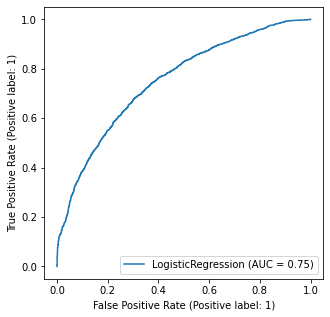

In [846]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, log_reg.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"


### Training Dataset metrics and ROC-AUC Curve
log_reg = LogisticRegression(random_state =10)
log_reg.fit(X_train, y_train)

print("\nTraining\n------------------------------------------------------------")

y_train_pred = log_reg.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(log_reg, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 69.98
ROC-AUC Score: 0.766

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       824
           1       0.71      0.69      0.70       835

    accuracy                           0.70      1659
   macro avg       0.70      0.70      0.70      1659
weighted avg       0.70      0.70      0.70      1659


Confusion Matrix:
[[583 241]
 [257 578]]

 ROC-AUC Curve for the validation set


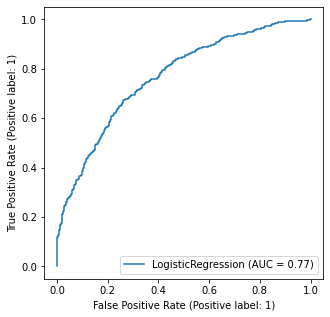

In [847]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")

y_val_pred = log_reg.predict(X_val)
error_metrics(y_val, y_val_pred, X_val)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(log_reg, X_val, y_val)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 67.57
ROC-AUC Score: 0.742

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       852
           1       0.66      0.69      0.67       807

    accuracy                           0.68      1659
   macro avg       0.68      0.68      0.68      1659
weighted avg       0.68      0.68      0.68      1659


Confusion Matrix:
[[568 284]
 [254 553]]

 ROC-AUC Curve for the testing set


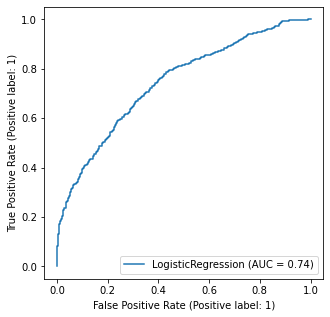

In [848]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = log_reg.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(log_reg, X_test, y_test)
plt.show()

Cumulative Gains Curve - Logistic Regression


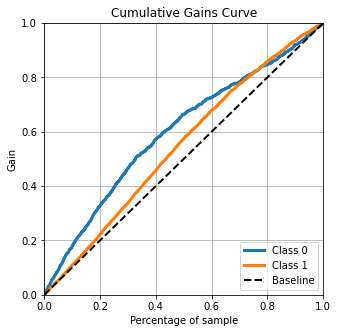

In [768]:
import scikitplot as skplt 

print("Cumulative Gains Curve - Logistic Regression")
skplt.metrics.plot_cumulative_gain(y_test, log_reg.predict_proba(X_test))
plt.show()

In [847]:
y_test.value_counts()

1    1685
0     845
Name: class_e, dtype: int64

In [689]:
import statsmodels.api as sm

In [849]:
logit = sm.Logit(y_train,sm.add_constant(X_train)).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                class_e   No. Observations:                 4974
Model:                          Logit   Df Residuals:                     4898
Method:                           MLE   Df Model:                           75
Date:                Sun, 13 Nov 2022   Pseudo R-squ.:                     inf
Time:                        17:49:10   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.2883      0.277      1.041      0.298      -0.255       0.831
Weight_of_cat                    -0.1695      0.083     -2.054      0.040      -0.331      -0.008
Tare_weight                      -0.0944      0.050     -1.902      0.057      -0.192       0.003
max_sum                          -0.2457      0.079     -3.094      0.002      -0.401      -0.090
mean_sum                          0.1353      0.141      0.958      0.338      -0.142       0.412
median_sum                        0.1831      0.104      1.752      0.080      -0.022       0.388
std_sum                           0.4427      0.051      8.726      0.000       0.343       0.542
Difference                        0.0493      0.035      1.392      0.164      -0.020       0.119
timestamp                         0.1648      0.039      4.280      0.000       0.089       0.240
Year_2021                         0.3927      0.167      2.357      0.018       0.066       0.719
Month_2                          -0.2721      0.245     -1.112      0.266      -0.752       0.208
Month_3                          -0.3689      0.152     -2.429      0.015      -0.667      -0.071
Month_4                          -0.6816      0.145     -4.709      0.000      -0.965      -0.398
Month_5                          -0.3902      0.165     -2.369      0.018      -0.713      -0.067
Month_6                           0.0465      0.416      0.112      0.911      -0.769       0.862
Month_7                          -0.3643      0.221     -1.650      0.099      -0.797       0.068
Month_8                          -0.1854      0.158     -1.170      0.242      -0.496       0.125
Month_9                          -0.2008      0.143     -1.400      0.162      -0.482       0.080
Month_10                         -0.1282      0.166     -0.773      0.440      -0.453       0.197
Month_11                          0.8262      0.321      2.573      0.010       0.197       1.455
Month_12                          0.4207      0.216      1.947      0.052      -0.003       0.844
Name_of_cat_Azure                -2.6342      0.285     -9.237      0.000      -3.193      -2.075
Name_of_cat_Betty Lou             0.3085      0.272      1.135      0.256      -0.224       0.841
Name_of_cat_Bill                 -1.4945      0.449     -3.327      0.001      -2.375      -0.614
Name_of_cat_Boots                 0.9334      0.334      2.792      0.005       0.278       1.589
Name_of_cat_Bucks                -0.5683      0.415     -1.368      0.171      -1.382       0.246
Name_of_cat_Cartman              -0.3074      0.294     -1.044      0.297      -0.885       0.270
Name_of_cat_Corned Beef           0.7278      0.344      2.114      0.035       0.053       1.403
Name_of_cat_Cracker Jack         -1.1813      0.259     -4.559      0.000      -1.689      -0.673
Name_of_cat_Doodle               -1.3307      0.383     -3.476      0.001      -2.081      -0.580
Name_of

###  Multiclass classification

In [730]:
log_reg=LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [732]:
y_pred = log_reg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.60      0.46      0.52       834
           1       0.58      0.83      0.68      1257
           2       0.43      0.09      0.15       440

    accuracy                           0.58      2531
   macro avg       0.54      0.46      0.45      2531
weighted avg       0.56      0.58      0.54      2531



In [733]:
confusion_matrix(y_test, y_pred)

array([[ 380,  434,   20],
       [ 179, 1044,   34],
       [  72,  328,   40]], dtype=int64)

In [734]:
y_prob = log_reg.predict_proba(X_test)
y_prob

array([[0.23613273, 0.66615385, 0.09771343],
       [0.35427071, 0.48106887, 0.16466042],
       [0.29423411, 0.36464977, 0.34111612],
       ...,
       [0.18148192, 0.69016899, 0.12834909],
       [0.1344292 , 0.5460082 , 0.3195626 ],
       [0.33436963, 0.57562161, 0.09000876]])

In [735]:
roc_auc_score(y_test,y_prob, multi_class='ovr')

0.7002523619484347

In [ ]:
# Get ROC metrics for each class
fpr = {}
tpr = {}
thresh ={}
for i in range(3):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob[:,i], pos_label=i)
    
# Plot the ROC chart
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue')
plt.show()

## Decision Tree 

In [850]:
from sklearn.tree import DecisionTreeClassifier
# entropy is criterion for id3 (interative dichotomizer) -type of tree
dtc=DecisionTreeClassifier(criterion='gini',max_depth=10,random_state=9)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=10, random_state=9)

In [726]:
y_prob=dtc.predict_proba(X_train).round(2)
y_pred = [0 if pval<0.52 else 1 for pval in y_prob[:,1]]  
y_pred

[0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,


In [728]:
error_metrics(y_train, y_pred, X_train)

Accuracy % age: 78.03
ROC-AUC Score: 0.854

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      5310
           1       0.80      0.74      0.77      5228

    accuracy                           0.78     10538
   macro avg       0.78      0.78      0.78     10538
weighted avg       0.78      0.78      0.78     10538


Confusion Matrix:
[[4378  932]
 [1383 3845]]


'Done'

In [743]:
fpr,tpr,thres=roc_curve(y_train,y_prob[:,1],drop_intermediate=False)
roc_df=pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thres':thres})
roc_df['Youden']=roc_df['TPR']-roc_df['FPR']
roc_df

,FPR,TPR,Thres,Youden
0,0.000000,0.000000,1.95,0.000000
1,0.000000,0.000191,0.95,0.000191
2,0.000188,0.000574,0.94,0.000386
3,0.000188,0.001148,0.93,0.000959
4,0.000188,0.001913,0.92,0.001724
...,...,...,...,...
92,0.981356,0.998087,0.04,0.016731
93,0.987571,0.998661,0.03,0.011090
94,0.994350,0.999426,0.02,0.005076
95,0.999247,1.000000,0.01,0.000753



Training
------------------------------------------------------------
Accuracy % age: 73.66
ROC-AUC Score: 0.825

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      2470
           1       0.73      0.77      0.75      2504

    accuracy                           0.74      4974
   macro avg       0.74      0.74      0.74      4974
weighted avg       0.74      0.74      0.74      4974


Confusion Matrix:
[[1746  724]
 [ 586 1918]]

 ROC-AUC Curve for the training set


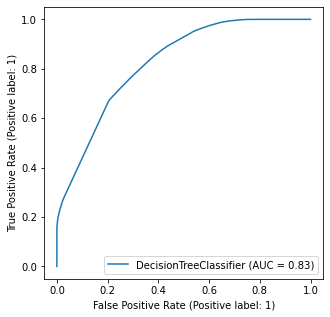


Validation
------------------------------------------------------------
Accuracy % age: 65.58
ROC-AUC Score: 0.694

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       824
           1       0.65      0.68      0.67       835

    accuracy                           0.66      1659
   macro avg       0.66      0.66      0.66      1659
weighted avg       0.66      0.66      0.66      1659


Confusion Matrix:
[[517 307]
 [264 571]]

 ROC-AUC Curve for the validation set


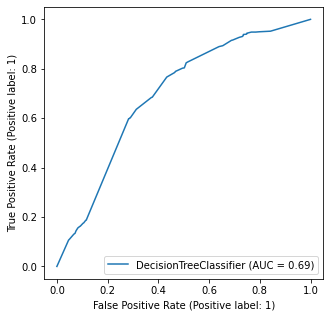


Testing
------------------------------------------------------------
Accuracy % age: 65.1
ROC-AUC Score: 0.693

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.63      0.65       852
           1       0.63      0.68      0.65       807

    accuracy                           0.65      1659
   macro avg       0.65      0.65      0.65      1659
weighted avg       0.65      0.65      0.65      1659


Confusion Matrix:
[[534 318]
 [261 546]]

 ROC-AUC Curve for the testing set


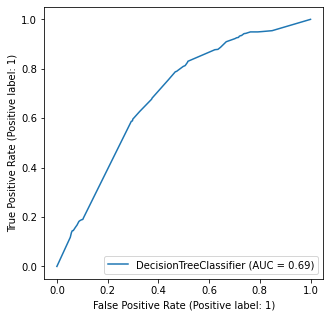

In [851]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, dtc.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"


print("\nTraining\n------------------------------------------------------------")
y_train_pred = dtc.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plt.rcParams['figure.figsize']=(5,5)
plot_roc_curve(dtc, X_train, y_train)
plt.show()

### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")

y_val_pred = dtc.predict(X_val)
error_metrics(y_val, y_val_pred, X_val)

print("\n ROC-AUC Curve for the validation set")
plt.rcParams['figure.figsize']=(5,5)
plot_roc_curve(dtc, X_val, y_val)
plt.show()

### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_pred = dtc.predict(X_test)
error_metrics(y_test, y_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plt.rcParams['figure.figsize']=(5,5)
plot_roc_curve(dtc, X_test, y_test)
plt.show()

## Random Forest

In [852]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 20, criterion = 'gini', random_state = 101,max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=101)


Training
------------------------------------------------------------
Accuracy % age: 76.3
ROC-AUC Score: 0.825

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      2470
           1       0.73      0.83      0.78      2504

    accuracy                           0.76      4974
   macro avg       0.77      0.76      0.76      4974
weighted avg       0.77      0.76      0.76      4974


Confusion Matrix:
[[1714  756]
 [ 423 2081]]

 ROC-AUC Curve for the training set


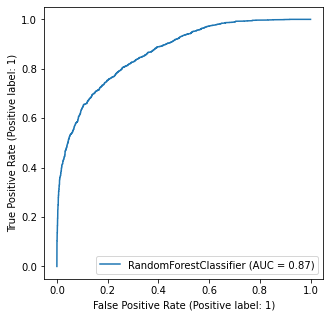

In [853]:
print("\nTraining\n------------------------------------------------------------")

y_train_pred = rf.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(rf, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 69.08
ROC-AUC Score: 0.694

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       824
           1       0.67      0.76      0.71       835

    accuracy                           0.69      1659
   macro avg       0.69      0.69      0.69      1659
weighted avg       0.69      0.69      0.69      1659


Confusion Matrix:
[[512 312]
 [201 634]]

 ROC-AUC Curve for the validation set


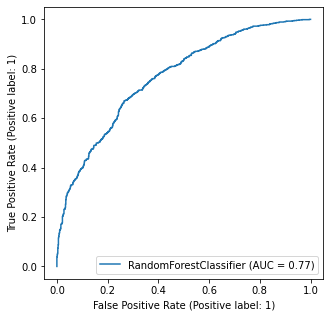

In [854]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_val_pred = rf.predict(X_val)
error_metrics(y_val, y_val_pred, X_val)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(rf, X_val, y_val)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 68.35
ROC-AUC Score: 0.693

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       852
           1       0.65      0.75      0.70       807

    accuracy                           0.68      1659
   macro avg       0.69      0.69      0.68      1659
weighted avg       0.69      0.68      0.68      1659


Confusion Matrix:
[[526 326]
 [199 608]]

 ROC-AUC Curve for the testing set


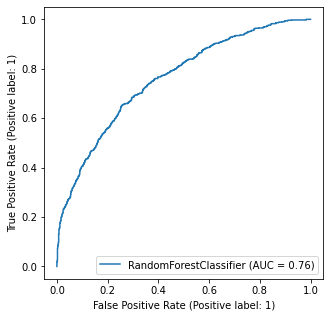

In [855]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = rf.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(rf, X_test, y_test)
plt.show()

In [1383]:
### Drivers of response

xgb_imp_df = pd.DataFrame()
xgb_imp_df['cols'] = X_train.columns
xgb_imp_df['importance'] = rf.feature_importances_
xgb_imp_df = xgb_imp_df.sort_values(by="importance", ascending=False).reset_index(drop=True)
xgb_imp_df

,cols,importance
0,timestamp,0.152561
1,std_sum,0.080137
2,Name_of_cat_Azure,0.075513
3,Weight_of_cat,0.072748
4,Difference,0.068463
...,...,...
70,Name_of_cat_Nimbus,0.000473
71,Name_of_cat_Tiana,0.000226
72,Name_of_cat_Bill,0.000189
73,Name_of_cat_Lando,0.000176



### Multiclass

In [662]:
y_pred = rf.predict(X_test)

In [663]:
import sklearn.metrics as metrics
metrics.accuracy_score(y_test, y_pred)

0.5732911892532596

In [664]:
y_prob = rf.predict_proba(X_test)
y_prob

array([[0.11787803, 0.18555498, 0.69656699],
       [0.14425049, 0.34973044, 0.50601907],
       [0.44496677, 0.22365918, 0.33137405],
       ...,
       [0.101936  , 0.18647292, 0.71159108],
       [0.21239322, 0.23817605, 0.54943073],
       [0.10905667, 0.4472027 , 0.44374063]])

In [665]:
roc_auc_score(y_test,y_prob, multi_class='ovr')

0.7071530233806499

In [666]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
pre_macro = metrics.precision_score(y_test, y_pred, average="macro")
recall_macro = metrics.recall_score(y_test, y_pred, average="macro")
f1_macro_scikit = metrics.f1_score(y_test, y_pred, average="macro")
print ("Prec_macro_scikit:", pre_macro)
print ("Rec_macro_scikit:", recall_macro)
print ("f1_macro_scikit:", f1_macro_scikit)

[[  40   54  346]
 [   5  311  518]
 [  19  138 1100]]
              precision    recall  f1-score   support

           d       0.62      0.09      0.16       440
          ne       0.62      0.37      0.47       834
           u       0.56      0.88      0.68      1257

    accuracy                           0.57      2531
   macro avg       0.60      0.45      0.44      2531
weighted avg       0.59      0.57      0.52      2531

Prec_macro_scikit: 0.6011239082814721
Rec_macro_scikit: 0.44630340422823384
f1_macro_scikit: 0.43565616610962027


In [759]:
from sklearn.tree import DecisionTreeClassifier
# entropy is criterion for id3 (interative dichotomizer) -type of tree
dtc=DecisionTreeClassifier(class_weight='balanced',max_depth=15,random_state=9)
dtc.fit(X_train,y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=15, random_state=9)

In [1247]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [1252]:
y_pred=knn.predict(X_test)
accuracy_score(y_test,y_pred)

0.6552139843279083

In [1256]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65       852
           1       0.64      0.68      0.66       807

    accuracy                           0.66      1659
   macro avg       0.66      0.66      0.66      1659
weighted avg       0.66      0.66      0.66      1659



## Boosting Techniques 
### XGboost

In [809]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier


### XGBoost Model to compare the results with the Logistic Regression model

xgb_weighted = XGBClassifier(verbosity = 0, random_state = 3)

grid_list = {'nthread':[4], 'objective':['binary:logistic'], 'learning_rate': [0.001, 0.01, 0.03],
             'max_depth': [5, 6, 7], 'min_child_weight': [3, 4], 'silent': [1],
             'subsample': [0.7], 'colsample_bytree': [0.7], 'n_estimators': [100]}

# initializing the gridsearch and finding optimum set of hyperparameters. Error metric used is roc_auc score.
# Training the gridsearch and finding the best model.
xgb_grid_search = GridSearchCV(estimator = xgb_weighted, param_grid = grid_list, cv = 10, n_jobs = 4, 
                               verbose = False, scoring = 'roc_auc')
xgb_grid_search.fit(X_train, y_train)
xgb_best_model = xgb_grid_search.best_estimator_


Training
------------------------------------------------------------
Accuracy % age: 75.76
ROC-AUC Score: 0.845

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.73      0.75      2437
           1       0.75      0.78      0.76      2444

    accuracy                           0.76      4881
   macro avg       0.76      0.76      0.76      4881
weighted avg       0.76      0.76      0.76      4881


Confusion Matrix:
[[1788  649]
 [ 534 1910]]

 ROC-AUC Curve for the training set


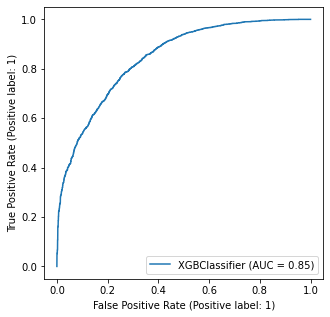

In [810]:
def error_metrics(actual, predicted, X_data):
    print('Accuracy % age: ' + str(np.round(accuracy_score(actual, predicted)*100, 2)))
    print('ROC-AUC Score: ' + str(np.round(roc_auc_score(actual, xgb_best_model.predict_proba(X_data)[:,1]),3)))
    print('\nClassification Report:')
    print(classification_report(actual, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(actual, predicted))
    return "Done"

print("\nTraining\n------------------------------------------------------------")
y_train_pred = xgb_best_model.predict(X_train)
error_metrics(y_train, y_train_pred, X_train)

print("\n ROC-AUC Curve for the training set")
plot_roc_curve(xgb_best_model, X_train, y_train)
plt.show()


Validation
------------------------------------------------------------
Accuracy % age: 68.9
ROC-AUC Score: 0.774

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       797
           1       0.69      0.70      0.70       830

    accuracy                           0.69      1627
   macro avg       0.69      0.69      0.69      1627
weighted avg       0.69      0.69      0.69      1627


Confusion Matrix:
[[541 256]
 [250 580]]

 ROC-AUC Curve for the validation set


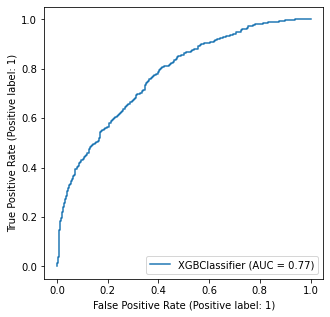

In [811]:
### Validation Dataset metrics and ROC-AUC Curve
print("\nValidation\n------------------------------------------------------------")
y_val_pred = xgb_best_model.predict(X_val)
error_metrics(y_val, y_val_pred, X_val)

print("\n ROC-AUC Curve for the validation set")
plot_roc_curve(xgb_best_model, X_val, y_val)
plt.show()


Testing
------------------------------------------------------------
Accuracy % age: 67.14
ROC-AUC Score: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67       834
           1       0.66      0.69      0.67       794

    accuracy                           0.67      1628
   macro avg       0.67      0.67      0.67      1628
weighted avg       0.67      0.67      0.67      1628


Confusion Matrix:
[[546 288]
 [247 547]]

 ROC-AUC Curve for the testing set


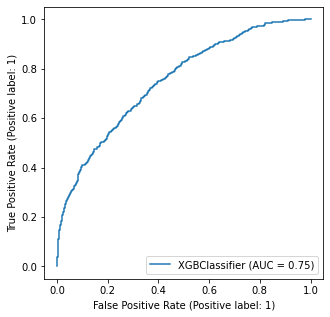

In [812]:
### Testing Dataset metrics and ROC-AUC Curve
print("\nTesting\n------------------------------------------------------------")
y_test_pred = xgb_best_model.predict(X_test)
error_metrics(y_test, y_test_pred, X_test)

print("\n ROC-AUC Curve for the testing set")
plot_roc_curve(xgb_best_model, X_test, y_test)
plt.show()

Cumulative Gains Curve - XGBoost


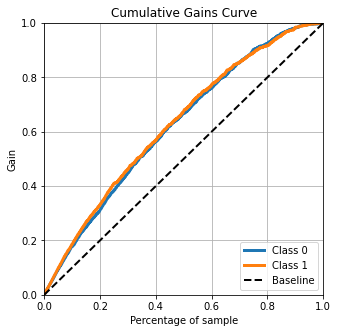

In [813]:
print("Cumulative Gains Curve - XGBoost")
skplt.metrics.plot_cumulative_gain(y_test, xgb_best_model.predict_proba(X_test))
plt.show()

In [814]:
pval = logit.pvalues.round(3)
impt_feat = pval[pval<0.05].index
logit = sm.Logit(y_train,sm.add_constant(X_train[impt_feat])).fit()
logit.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                class_e   No. Observations:                 4881
Model:                          Logit   Df Residuals:                     4839
Method:                           MLE   Df Model:                           41
Date:                Sun, 13 Nov 2022   Pseudo R-squ.:                     inf
Time:                        17:42:14   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.0674      0.130      0.520      0.603      -0.186       0.321
Tare_weight                      -0.1146      0.053     -2.159      0.031      -0.219      -0.011
mean_sum                          0.3148      0.072      4.399      0.000       0.175       0.455
std_sum                           0.4463      0.046      9.760      0.000       0.357       0.536
timestamp                         0.1911      0.033      5.732      0.000       0.126       0.256
waste                            -0.1816      0.065     -2.810      0.005      -0.308      -0.055
Weight                           -0.3069      0.051     -5.985      0.000      -0.407      -0.206
Year_2021                         0.3603      0.138      2.611      0.009       0.090       0.631
Month_4                          -0.4386      0.114     -3.842      0.000      -0.662      -0.215
Month_11                          1.4063      0.288      4.889      0.000       0.843       1.970
Month_12                          0.6629      0.169      3.932      0.000       0.333       0.993
Name_of_cat_Azure                -2.5552      0.213    -12.002      0.000      -2.972      -2.138
Name_of_cat_Bill                 -1.4712      0.397     -3.701      0.000      -2.250      -0.692
Name_of_cat_Bucks                -0.9581      0.458     -2.093      0.036      -1.855      -0.061
Name_of_cat_Corned Beef           0.9633      0.282      3.417      0.001       0.411       1.516
Name_of_cat_Cracker Jack         -1.3408      0.194     -6.919      0.000      -1.721      -0.961
Name_of_cat_Doodle               -0.6576      0.284     -2.319      0.020      -1.213      -0.102
Name_of_cat_Espresso             -0.7871      0.320     -2.458      0.014      -1.415      -0.160
Name_of_cat_Fable                -0.5752      0.184     -3.121      0.002      -0.936      -0.214
Name_of_cat_Fender               -1.5735      0.231     -6.815      0.000      -2.026      -1.121
Name_of_cat_Frank                 1.5034      0.493      3.052      0.002       0.538       2.469
Name_of_cat_Gramps               -1.2004      0.319     -3.763      0.000      -1.826      -0.575
Name_of_cat_Gremlin               1.9193      0.291      6.589      0.000       1.348       2.490
Name_of_cat_Husker               -0.6198      0.183     -3.381      0.001      -0.979      -0.261
Name_of_cat_Jason Voorhees       -0.7326      0.226     -3.244      0.001      -1.175      -0.290
Name_of_cat_Kansas               -0.9658      0.242     -3.989      0.000      -1.440      -0.491
Name_of_cat_Kat                  -0.6861      0.152     -4.509      0.000      -0.984      -0.388
Name_of_cat_Lexi                  2.7254      1.027      2.653      0.008       0.712       4.739
Name_of_cat_Monte                -0.8453      0.251     -3.363      0.001      -1.338      -0.353
Name_of_cat_Mrs. Buttersworth     0.9042      0.196      4.614      0.000       0.520       1.288
Name_of

In [227]:
import scipy.stats as stats